In [1]:
# %matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pylab
import math
import sys
import operator
import inspect
import lmfit
from lmfit import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal
from scipy import fftpack
from scipy.integrate import trapz
from operator import itemgetter
from skimage import util
from scipy import stats
from numpy import NaN, Inf, arange, isscalar, asarray, array
##################################################    PEAK DETECTOR     ###############################################
def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)
##################################################    FITTING MODELS     ##############################################

def model(t, decay):  # , omega, resid):
    return np.exp(-t/decay)  # * np.cos(omega * t) + resid
gmodel = lmfit.Model(model)
def line(x, slope, intercept):
    """a line"""
    return 10**((slope*np.log(x))-intercept)
mod = Model(line)

def line2(x, slope, intercept):
    """a line"""
    return slope*x+intercept


def adjust_yaxis(ax,ydif,v):
    """shift axis ax by ydiff, maintaining point v at the same location"""
    inv = ax.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, ydif))
    miny, maxy = ax.get_ylim()
    miny, maxy = miny - v, maxy - v
    if -miny>maxy or (-miny==maxy and dy > 0):
        nminy = miny
        nmaxy = miny*(maxy+dy)/(miny+dy)
    else:
        nmaxy = maxy
        nminy = maxy*(miny+dy)/(maxy+dy)
    ax.set_ylim(nminy+v, nmaxy+v)
    
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    adjust_yaxis(ax2,(y1-y2)/2,v2)
    adjust_yaxis(ax1,(y2-y1)/2,v1)

#################################################    NAME RETREIVER     ###############################################

def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]
            
###################################################    VALUE FINDER     ###############################################
            
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

##############################################    DIAGNOSTIC TOOL     #############################################

def diag(filename, spectrogram=False, plot=False, Lx=None, omt=None, mxtime=None):
    
    kx = (np.pi*2/Lx)
    if omt == 6:
        Q = [( pylab.loadtxt('./{0}/ITGa_NL/omt6/nrgsummaryions_act.dat'.format(filename),usecols = (0, 2)))][0]
    elif omt == 10:
        Q = [( pylab.loadtxt('./{0}/ITGa_NL/omt10/nrgsummaryions_act.dat'.format(filename),usecols = (0, 2)))][0]
        
    if omt == 6:
        nl_gam = [( pylab.loadtxt('./{0}/ITGa_NL/omt6/gamdiagions_act.dat'.format(filename),usecols = (0, 1)))][0]
    elif omt == 10:
        nl_gam = [( pylab.loadtxt('./{0}/ITGa_NL/omt10/gamdiagions_act.dat'.format(filename),usecols = (0, 1)))][0]
    
    data = pylab.loadtxt('{0}/GAM/{1}/gamdiagions_act.dat'.format(filename, Lx)) # Load the .dat files as an array

    if plot == True:
        fig, ax1 = plt.subplots(figsize=(13, 7))
        ax2 = ax1.twinx()
        #plt.title("{0}".format(filename), fontsize=30)
        #plt.xscale('log')
        ax1.set_xlabel('Time ($a / v_{ti}$)',fontsize=16)
        ax1.set_ylabel('$\phi (t) / \phi (0)$',fontsize=16)
    
    E = ((data[:,1]*(1/data[0, 1])))
    t = data[:,0]
    if mxtime != None:
        t_f = (np.abs(t - mxtime)).argmin()
        t_f2 = (np.abs(Q[:, 0] - mxtime)).argmin()
        t_f3 = (np.abs(nl_gam[:, 0] - mxtime)).argmin()
    else:
        t_f = (np.abs(t - t[-1])).argmin()
        t_f2 = (np.abs(Q[:, 0] - Q[-1, 0])).argmin()
        t_f3 = (np.abs(nl_gam[:, 0] - nl_gam[-1, 0])).argmin()
    E = E[:t_f]
    t = t[:t_f]

    if plot == True:
        lns1 = ax1.plot(t, E, linewidth=3, label=('k_x: ', kx))
    #integ = (np.trapz(E, t))
    integ = np.sqrt(np.mean(E**2))
        
    lns2 = ax2.plot(Q[:t_f2, 0], Q[:t_f2, 1], 'r', linewidth=3, label='$\\langle Q_{ES} \\rangle$')
    nl_gam_t = nl_gam[:t_f3, 0]
    nl_gam = (nl_gam[:t_f3,1]*(1/nl_gam[0, 1]))
    integ_nl = np.trapz(nl_gam, nl_gam_t)
    integ_nl = np.sqrt(np.mean(nl_gam**2))
    lns3 = ax1.plot(nl_gam_t, nl_gam, 'g', linewidth=3, label='GAM from NL simulation')
    #ax1.set_xlim([-10, max(t)])
    #ax1.set_xlim([-10, 1000])
    #ax1.set_ylim([-0.6, 1.1])
    ax2.set_ylabel('$\\langle \Gamma_{ES} \\rangle \ / \ (v_{ti} \\rho_{i}^{2} n_{e, 0} / L_{ref}^{2})$', fontsize=16)
    #np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
    lns = lns1+lns2+lns3
    labs = [l.get_label() for l in lns]
    plt.legend(lns, labs, loc='center right')
    fig.tight_layout()
    align_yaxis(ax1, 0, ax2, 0)
    ax2.axhline(y=0, color='black', linestyle='dashed')
    #plt.savefig('../../CMSS_2018/Poster/Salpha_nlzf_plot.pdf', format='pdf', dpi=1200)
    plt.show()


    if spectrogram == True:
        ########  SPECTROGRAM
        f_s = len(data[:, 0]) / data[-1, 0]
        E = (data[:,1]*(1/data[0, 1]))
        M = 1024
        slices = util.view_as_windows(E, window_shape=(M,), step=2)
        win = np.hanning(M + 1)[:-1]
        slices = slices * win
        slices = slices.T
        spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
        spectrum = np.abs(spectrum)
        S = np.abs(spectrum)
        S = 20 * np.log10(S / np.max(S))
        plt.figure()
        plt.imshow(S, origin='lower', cmap='viridis')
        plt.title(str(label), fontsize=30)
        plt.axis('tight')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time ($a / v_{ti}$)')
        #plt.ylim([0, 0.3])

    #f_s = len(data[:, 0]) / data[-1, 0]
    return integ, integ_nl

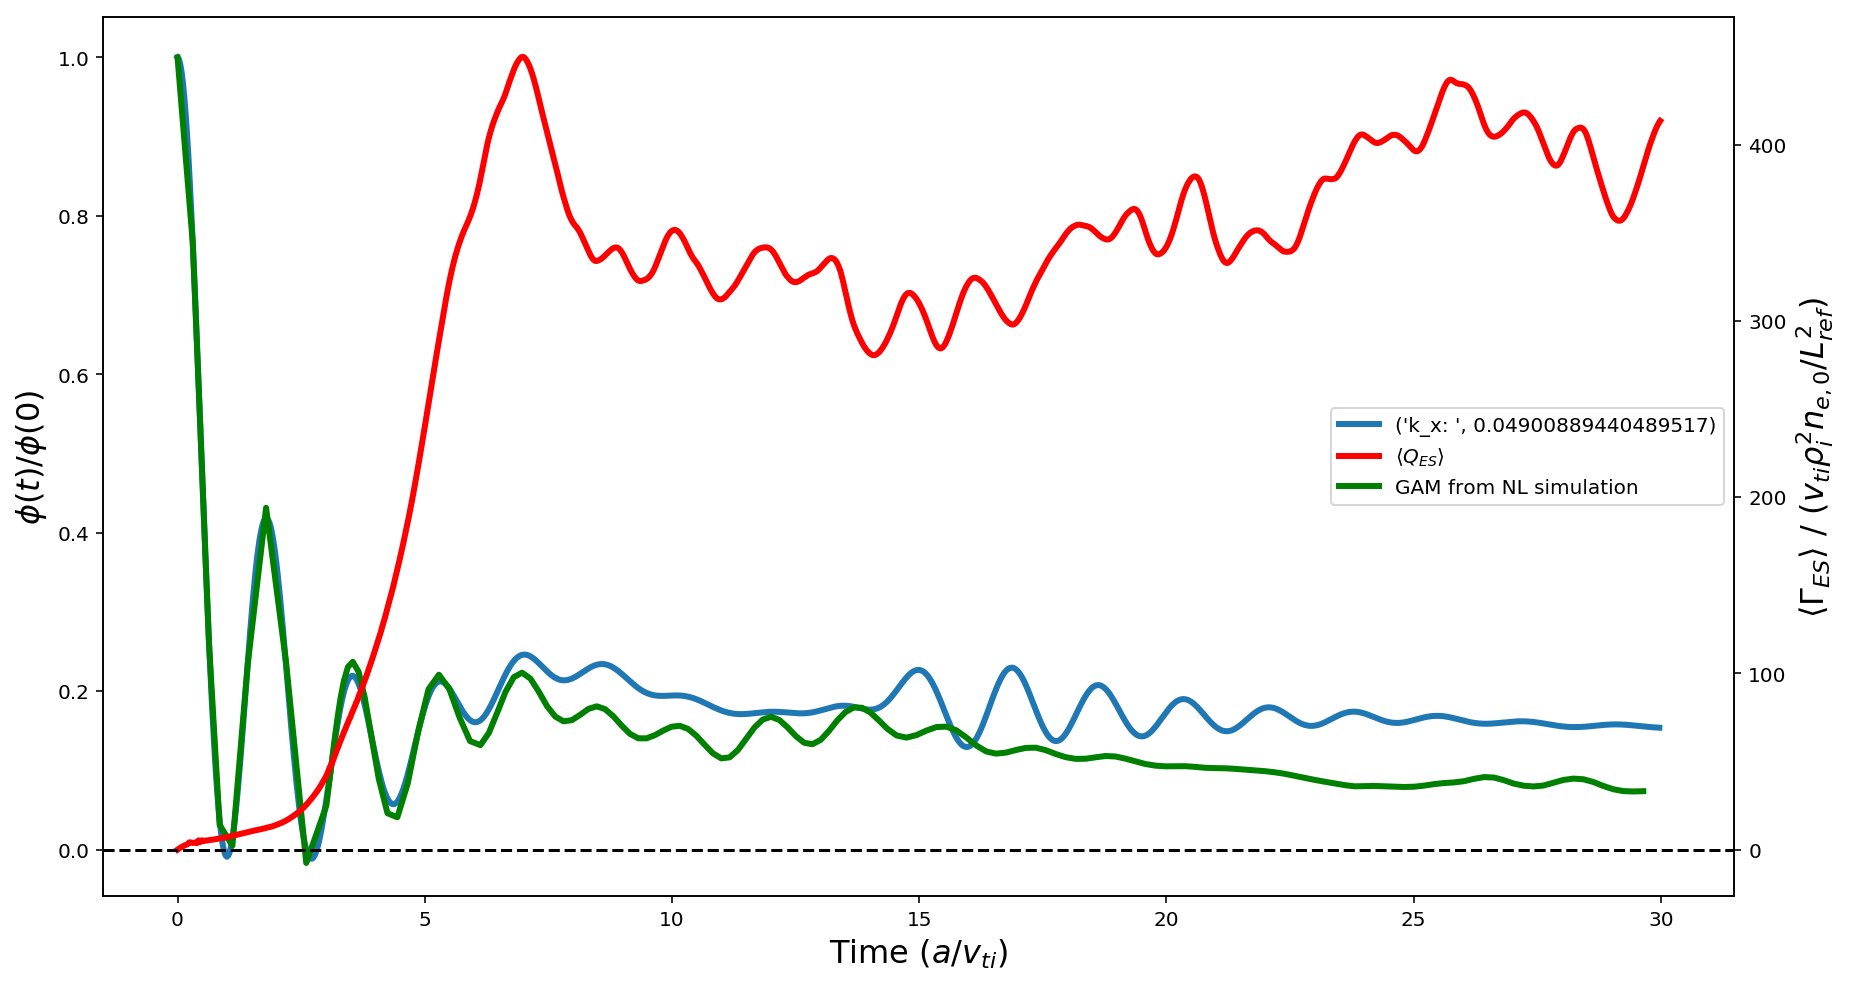

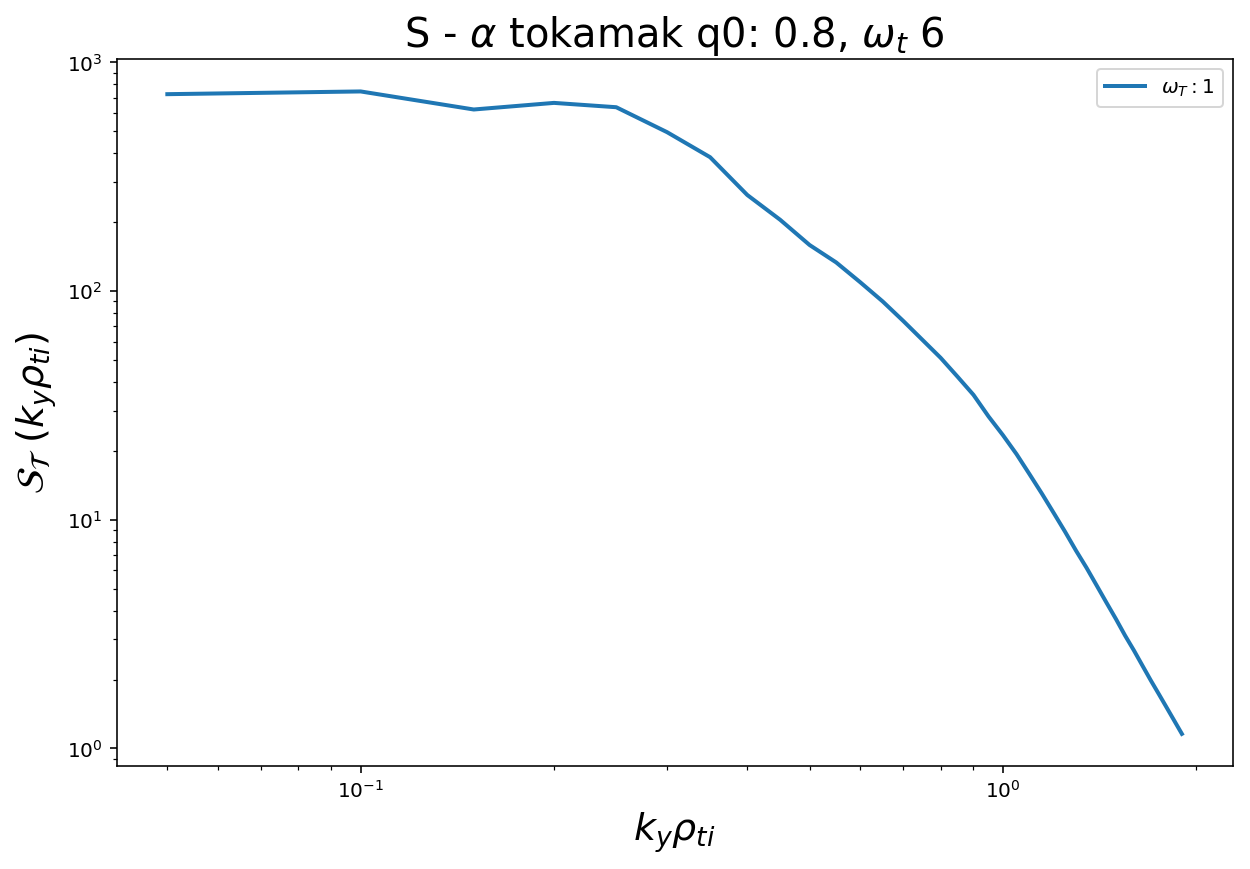

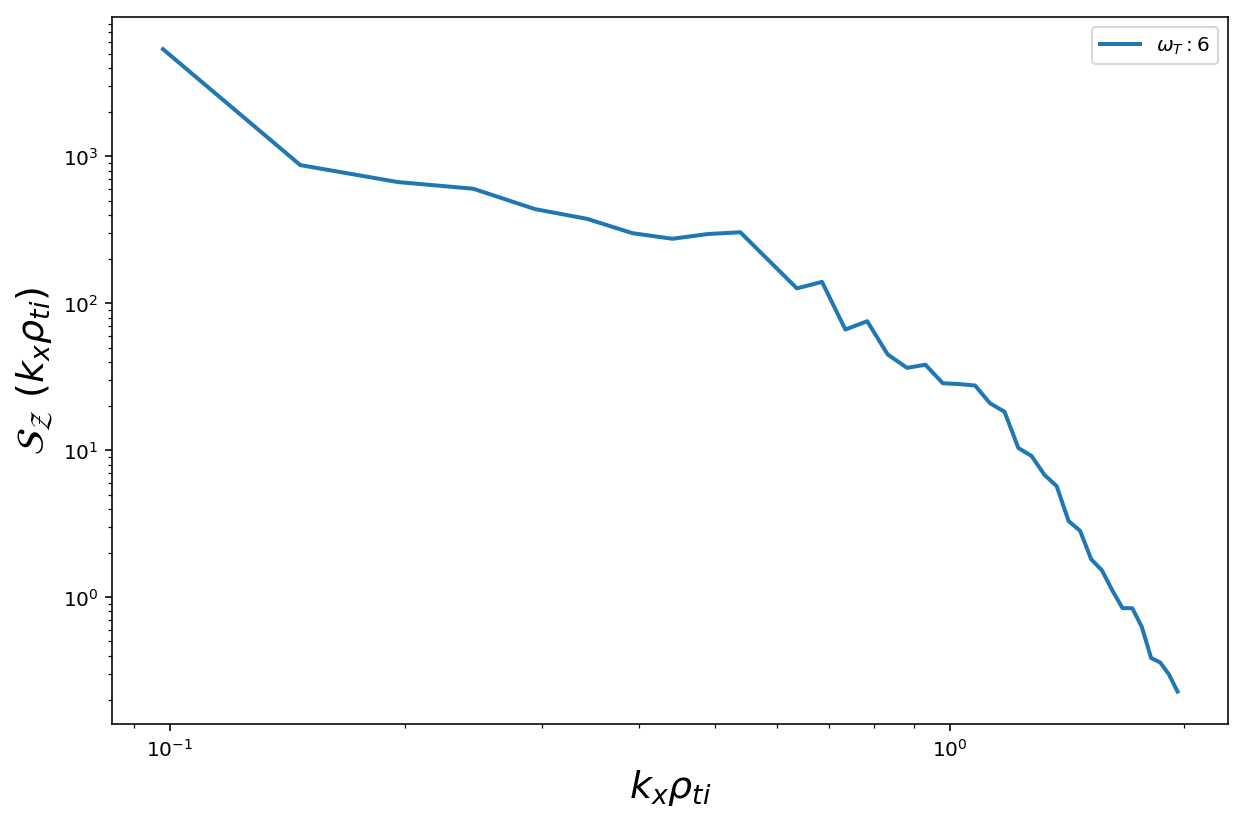

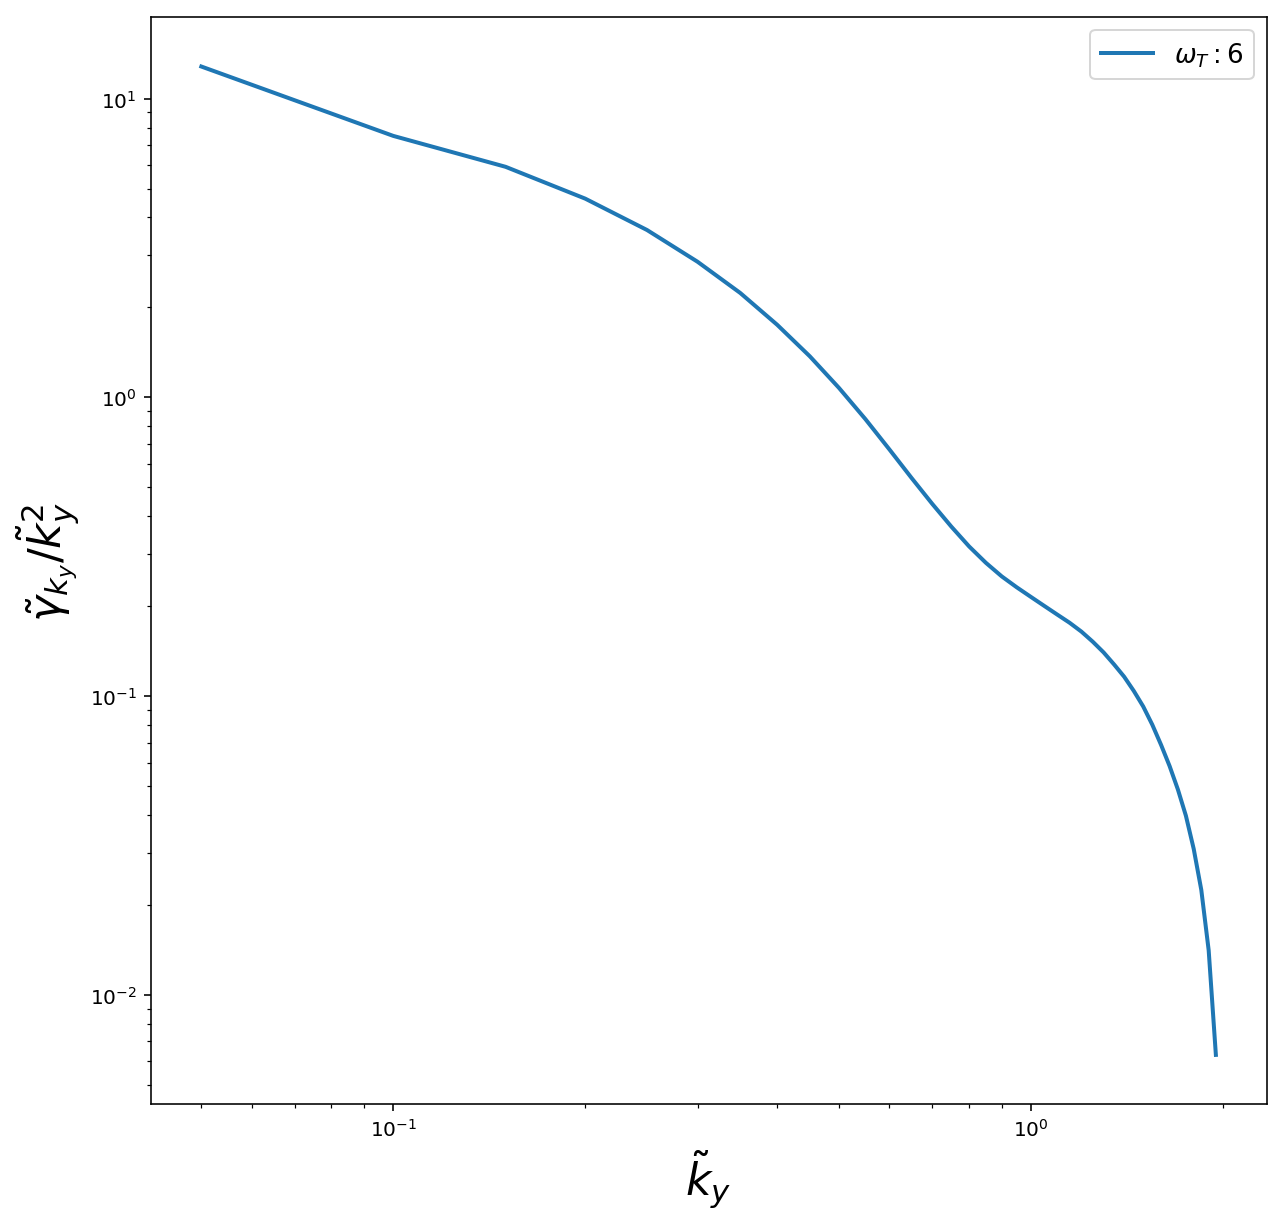

S-alpha geometry q0:0.8 omt:6 

T total:    264.748634458
Z total:    378.04164815204075
Sum g/k^2:   49.739000128468426
Tau:        0.21172406914869904


In [2]:
#111111111111111111111111111111111111111#
#1 STee maker & file loader            1#
#1 for S-alpha geometry, q0=0.8, omt=6 1#
#111111111111111111111111111111111111111#

# Load data
sa = [( pylab.loadtxt('q0-0.8/ITGa_NL/omt6/spectraions_act.dat',usecols = (0, 1)))][0]

#### Simulation parameters
nkx0 = 384
nky0 = 64
Lx = 128.205
kx_minimum = 0.049
ky_minimum = 0.05
t_final = 126.87048
t_sat = 8.46

Ts_sa08omt6 = 350         # Simulation temperature
TN_sa08omt6 = 2160        # Model reference temperature
rhos_sa08omt6 = 0.0027    # Simulation gyroradius
rhoN_sa08omt6 = 0.0018    # Model reference gyroradius

#### Geomertic parameters (Not very relevant)
q0       =    0.8
shat     =   0.78
trpeps   =   0.10
major_R  =    4.0

top = np.int(nkx0/2)

######################## Containers:
ky_sa08omt6 = np.zeros((top, nky0))
phisa = np.zeros((top, nky0))
St_sa08omt6 = np.zeros((nky0))
########################

# Extract ky and Phi for each omt
for n in range(0, top):
    lo = (0+(nky0*n))
    hi = (nky0+(nky0*n))
    ky_sa08omt6[n] = sa[lo:hi, 0]
    phisa[n] = sa[lo:hi, 1]
    np.add(St_sa08omt6, phisa[n]/ky_minimum, out=St_sa08omt6, where=True)

tzf_sa08omt6, tzf_sa08omt6_nl = diag('q0-0.8', plot=True, Lx=Lx, omt=6, mxtime=30)
hi = (nky0+(nky0*(top-1)))
kx_sa08omt6 = sa[hi:(hi+top), 0]
Sz_sa08omt6 = sa[hi:(hi+top), 1]/kx_minimum

############
kx_cut = (np.abs(kx_sa08omt6 - kx_minimum)).argmin()  # Implies that the minimum kx to compare comes from NL
kx_cut_max = (np.abs(kx_sa08omt6 - 2.0)).argmin()
kx_sa08omt6 = kx_sa08omt6[kx_cut+1:kx_cut_max]
Sz_sa08omt6 = Sz_sa08omt6[kx_cut+1:kx_cut_max]

ky_cut_max = (np.abs(ky_sa08omt6[1, 1:] - 2.0)).argmin()
ky_sa08omt6 = ky_sa08omt6[1, 1:ky_cut_max]
St_sa08omt6 = St_sa08omt6[1:ky_cut_max]
############

#idx2 = (np.abs(ky_sa08omt6 - 1.0)).argmin()
#idx2f = idx2+35
#Y = St_sa08omt6[idx2:idx2f]
#X = ky_sa08omt6[1, idx2:idx2f]
#pars = mod.make_params(intercept=-1.42, slope=-1.96)
#out = mod.fit(Y, pars, x=X, nan_policy='propagate')
#print(out.fit_report(min_correl=0.25))

plt.figure(figsize=(10, 6.5))
plt.title("S - $\\alpha$ tokamak q0: 0.8, $\omega _{t}$ 6", fontsize=20)
plt.plot(ky_sa08omt6, St_sa08omt6, linewidth=2)  # Printing: the truncated range with normalisation
#plt.plot(X, out.init_fit, 'k--')
#plt.plot(X, out.best_fit, 'r-')
plt.legend(['$\omega_{T}: 1$', 'Init fit', 'Final fit'], fontsize=10)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{y}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{T}} \ (k_{y} \\rho_{ti})$',fontsize=19)
#plt.savefig('sa08_st_plot.eps', format='eps', dpi=1200)
plt.show()

plt.figure(figsize=(10, 6.5))
plt.plot(kx_sa08omt6, Sz_sa08omt6, linewidth=2)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{x}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{Z}} \ (k_{x} \\rho_{ti})$',fontsize=19)
plt.legend(['$\omega_{T}: 6$', '$\\tau_{ZF}$', 'Overshoot Ratio'], fontsize=10)
#plt.savefig('sa08_sz_plot.eps', format='eps', dpi=1200)
plt.show()

####### Load Linear simulations growth rates #######
datalist2 = [ pylab.loadtxt('./q0-0.8/ITGa_l/omt6.dat',usecols = (0, 2, 4, 5)) ][0]
ky_min = datalist2[:, 1]
gamma = datalist2[:, 2]
omega = datalist2[:, 3]

ky_cut2 = (np.abs(ky_min - 2.0)).argmin()
ky = ky_min[:ky_cut2]
g = gamma[:ky_cut2]

plt.figure(figsize=(10, 10))
plt.plot(ky, g/(ky**2), linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(['$\omega_{T}: 6$'], fontsize=13)
plt.xlabel('$\\tilde{k}_{y}$',fontsize=22)
plt.ylabel('$\\tilde{\gamma}_{k_{y}} / \\tilde{k}^{2}_{y}$',fontsize=22)
plt.show()

appT_sa08omt6 = np.nansum(g/(ky**2))
te_sa08omt6 = trapz(St_sa08omt6, x=ky_sa08omt6)
zet_sa08omt6 = trapz(Sz_sa08omt6, x=kx_sa08omt6)
#slope_sa08omt6, intercept = out.best_values.values()

print('S-alpha geometry q0:0.8 omt:6 \n')
#print('S_T slope  ', slope_sa08omt6)
print('T total:   ', te_sa08omt6)
print('Z total:   ', zet_sa08omt6)
print('Sum g/k^2:  ', appT_sa08omt6)
print('Tau:       ', tzf_sa08omt6)

#111111111111111111111111111111111111111#
#1 STee maker & file loader            1#
#1 for S-alpha geometry, q0=0.8, omt=6 1#
#111111111111111111111111111111111111111#

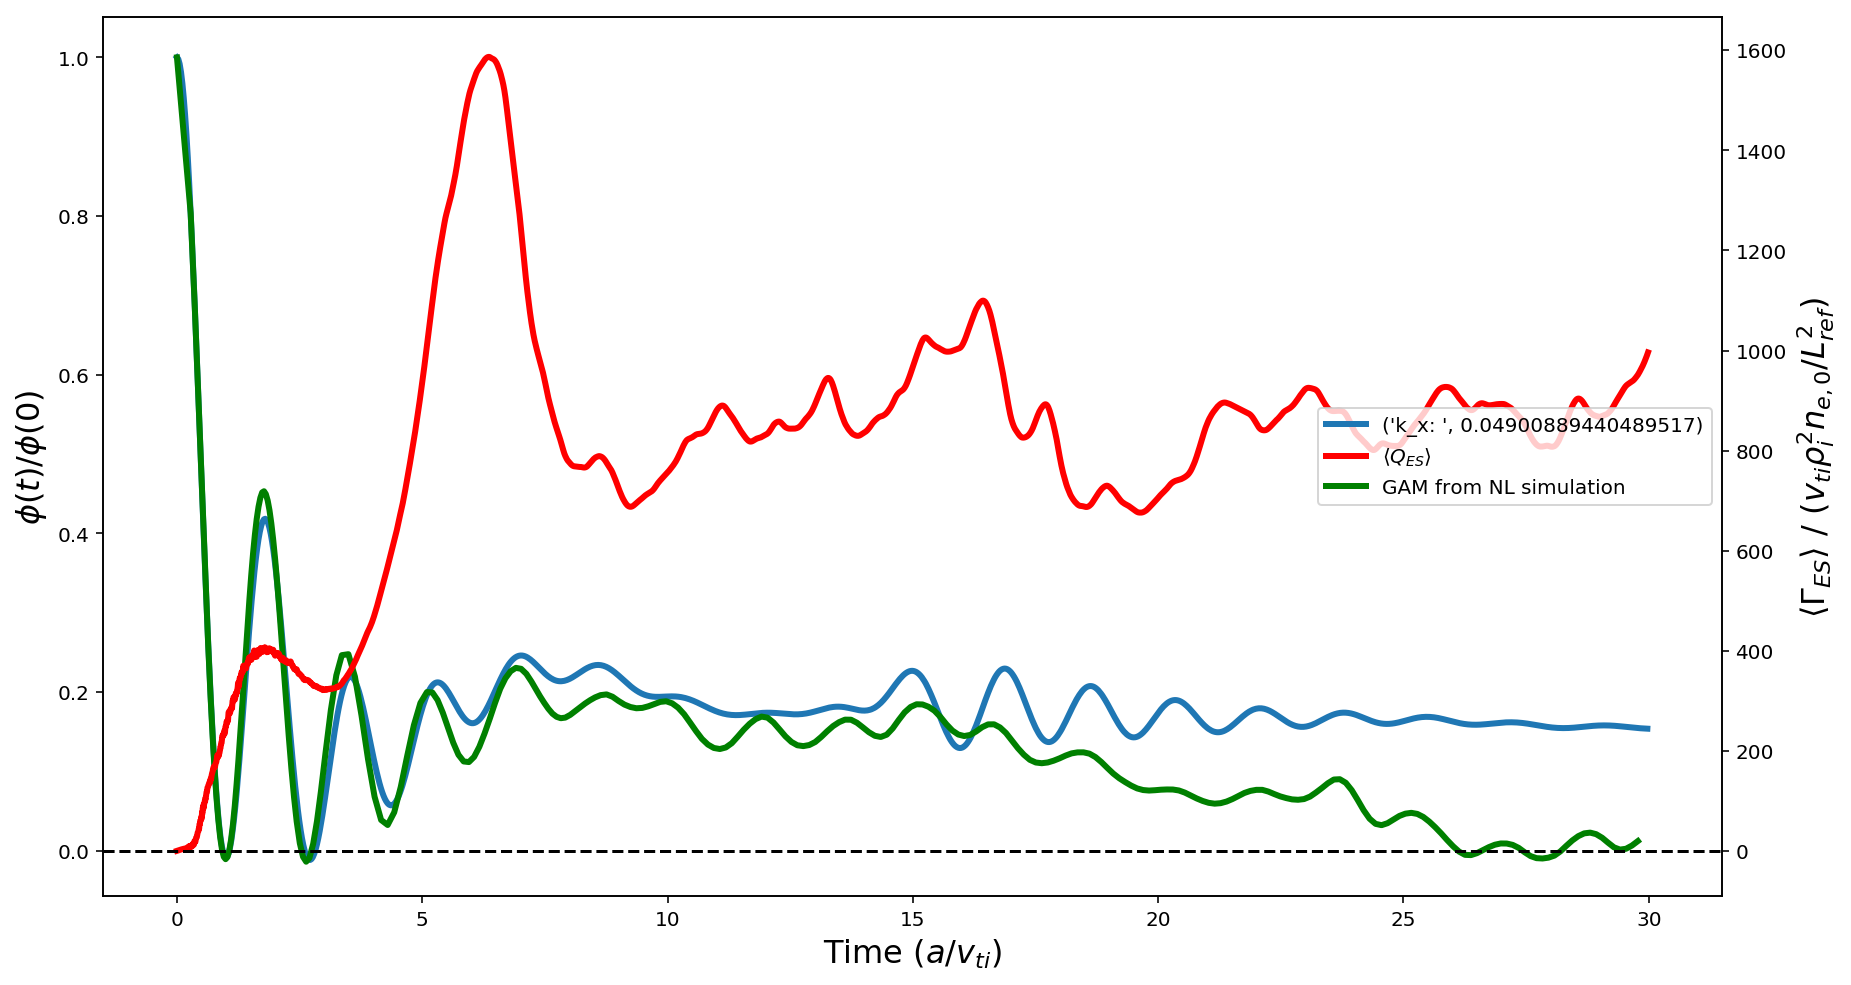

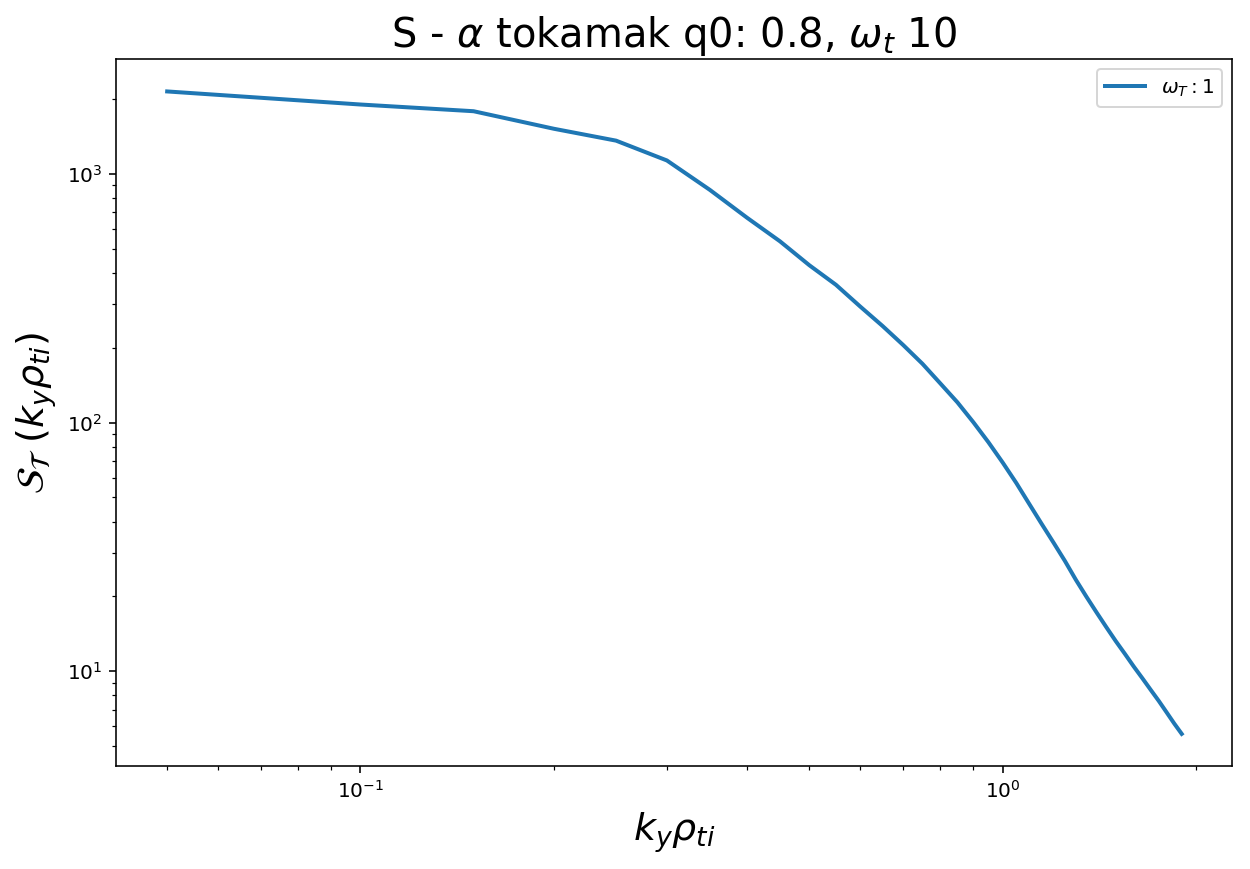

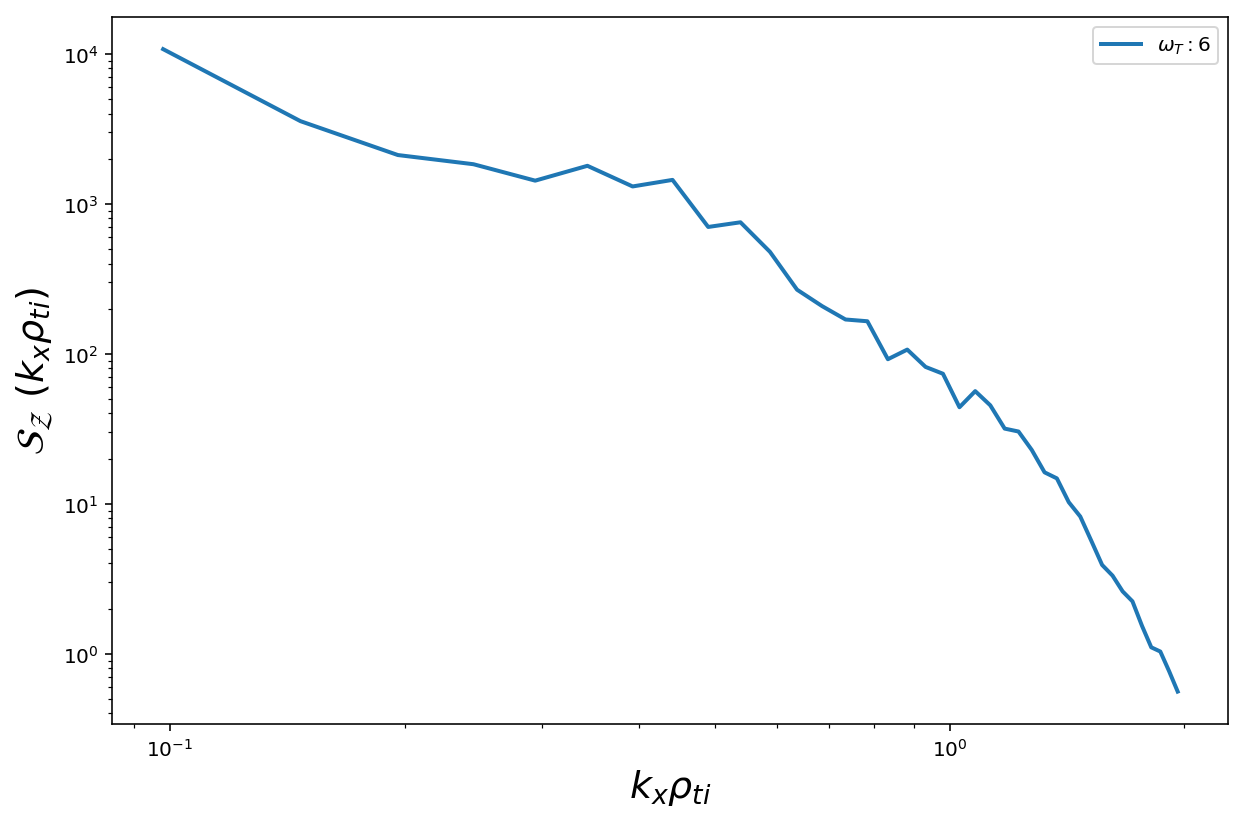

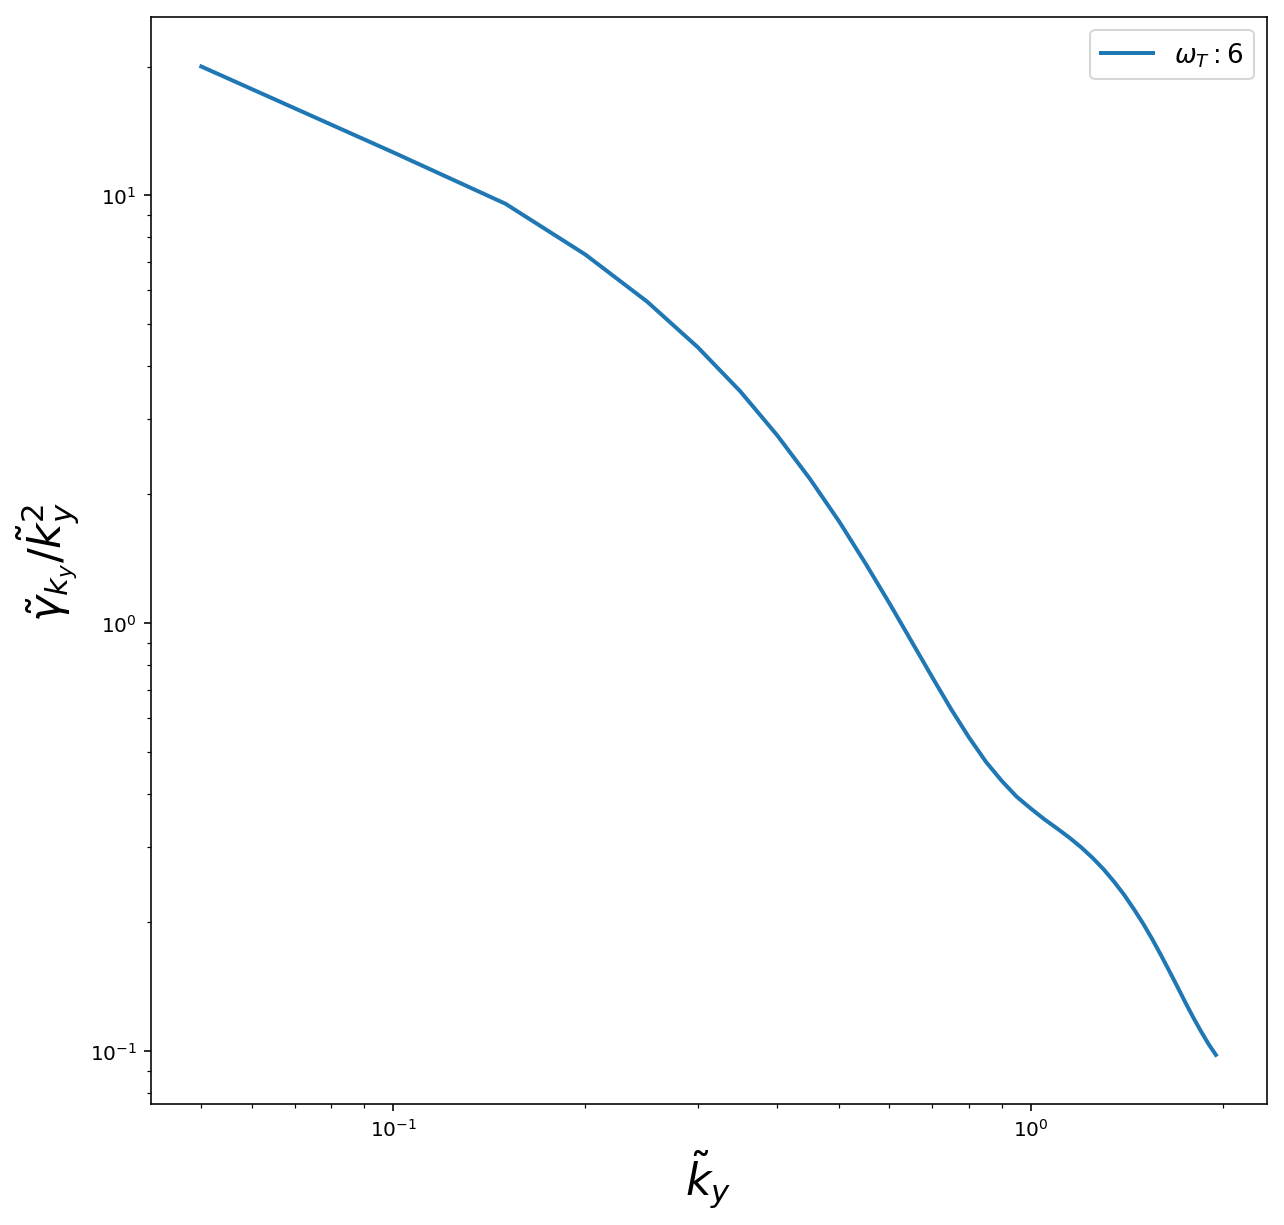

S-alpha geometry q0:0.8 omt:10 

T total:    670.85222133
Z total:    1092.0797674632654
Sum g/k^2:   80.5777072945397
Tau:        0.21172406914869904


In [35]:
#2222222222222222222222222222222222222222#
#2 STee maker & file loader             2#
#2 for S-alpha geometry, q0=0.8, omt=10 2#
#2222222222222222222222222222222222222222#

# Load data
sa = [( pylab.loadtxt('q0-0.8/ITGa_NL/omt10/spectraions_act.dat',usecols = (0, 1)))][0]

#### Simulation parameters
nkx0 = 384
nky0 = 64
Lx = 128.205
kx_minimum = 0.049
ky_minimum = 0.05
t_final = 57.845631
t_sat = 9.5

Ts_sa08omt10 = 350         # Simulation temperature
TN_sa08omt10 = 2160        # Model reference temperature
rhos_sa08omt10 = 0.0027    # Simulation gyroradius
rhoN_sa08omt10 = 0.0018    # Model reference gyroradius

#### Geomertic parameters (Not very relevant)
q0       =    0.8
shat     =   0.78
trpeps   =   0.10
major_R  =    4.0

top = np.int(nkx0/2)

######################## Containers:
ky_sa08omt10 = np.zeros((top, nky0))
phisa = np.zeros((top, nky0))
St_sa08omt10 = np.zeros((nky0))
########################

# Extract ky and Phi for each omt
for n in range(0, top):
    lo = (0+(nky0*n))
    hi = (nky0+(nky0*n))
    ky_sa08omt10[n] = sa[lo:hi, 0]
    phisa[n] = sa[lo:hi, 1]
    np.add(St_sa08omt10, phisa[n]/ky_minimum, out=St_sa08omt10, where=True)

tzf_sa08omt10, tzf_sa08omt10_nl = diag('q0-0.8', plot=True, Lx=Lx, omt=10, mxtime=30)
hi = (nky0+(nky0*(top-1)))
kx_sa08omt10 = sa[hi:(hi+top), 0]
Sz_sa08omt10 = sa[hi:(hi+top), 1]/kx_minimum

#############
kx_cut = (np.abs(kx_sa08omt10 - kx_minimum)).argmin()   # Implies that the minimum kx to compare comes from NL
kx_cut_max = (np.abs(kx_sa08omt10 - 2.0)).argmin()
kx_sa08omt10 = kx_sa08omt10[kx_cut+1:kx_cut_max]
Sz_sa08omt10 = Sz_sa08omt10[kx_cut+1:kx_cut_max]

ky_cut_max = (np.abs(ky_sa08omt10[1, 1:] - 2.0)).argmin()
ky_sa08omt10 = ky_sa08omt10[1, 1:ky_cut_max]
St_sa08omt10 = St_sa08omt10[1:ky_cut_max]
#############

#idx2 = (np.abs(ky_sa08omt10 - 1.0)).argmin()
#idx2f = idx2+35
#Y = St_sa08omt10[idx2:idx2f]
#X = ky_sa08omt10[1, idx2:idx2f]
#pars = mod.make_params(intercept=-1.42, slope=-1.96)
#out = mod.fit(Y, pars, x=X, nan_policy='propagate')
#print(out.fit_report(min_correl=0.25))

plt.figure(figsize=(10, 6.5))
plt.title("S - $\\alpha$ tokamak q0: 0.8, $\omega _{t}$ 10", fontsize=20)
plt.plot(ky_sa08omt10, St_sa08omt10, linewidth=2)  # Printing: the truncated range with normalisation
#plt.plot(X, out.init_fit, 'k--')
#plt.plot(X, out.best_fit, 'r-')
plt.legend(['$\omega_{T}: 1$', 'Init fit', 'Final fit'], fontsize=10)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{y}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{T}} \ (k_{y} \\rho_{ti})$',fontsize=19)
#plt.savefig('sa08_st_plot.eps', format='eps', dpi=1200)
plt.show()

plt.figure(figsize=(10, 6.5))
plt.plot(kx_sa08omt10, Sz_sa08omt10, linewidth=2)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{x}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{Z}} \ (k_{x} \\rho_{ti})$',fontsize=19)
plt.legend(['$\omega_{T}: 6$', '$\\tau_{ZF}$', 'Overshoot Ratio'], fontsize=10)
#plt.savefig('sa08_sz_plot.eps', format='eps', dpi=1200)
plt.show()

####### Load Linear simulations growth rates #######
datalist2 = [ pylab.loadtxt('./q0-0.8/ITGa_l/omt10.dat',usecols = (0, 2, 4, 5)) ][0]
ky_min = datalist2[:, 1]
gamma = datalist2[:, 2]
omega = datalist2[:, 3]

ky_cut2 = (np.abs(ky_min - 2.0)).argmin()
ky = ky_min[:ky_cut2]
g = gamma[:ky_cut2]

plt.figure(figsize=(10, 10))
plt.plot(ky, g/(ky**2), linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(['$\omega_{T}: 6$'], fontsize=13)
plt.xlabel('$\\tilde{k}_{y}$',fontsize=22)
plt.ylabel('$\\tilde{\gamma}_{k_{y}} / \\tilde{k}^{2}_{y}$',fontsize=22)
plt.show()

appT_sa08omt10 = np.nansum(g/(ky**2))
te_sa08omt10 = trapz(St_sa08omt10, x=ky_sa08omt10)
zet_sa08omt10 = trapz(Sz_sa08omt10, x=kx_sa08omt10)
#slope_sa08omt10, intercept = out.best_values.values()

print('S-alpha geometry q0:0.8 omt:10 \n')
#print('S_T slope  ', slope_sa08omt10)
print('T total:   ', te_sa08omt10)
print('Z total:   ', zet_sa08omt10)
print('Sum g/k^2:  ', appT_sa08omt10)
print('Tau:       ', tzf_sa08omt10)

#2222222222222222222222222222222222222222#
#2 STee maker & file loader             2#
#2 for S-alpha geometry, q0=0.8, omt=10 2#
#2222222222222222222222222222222222222222#

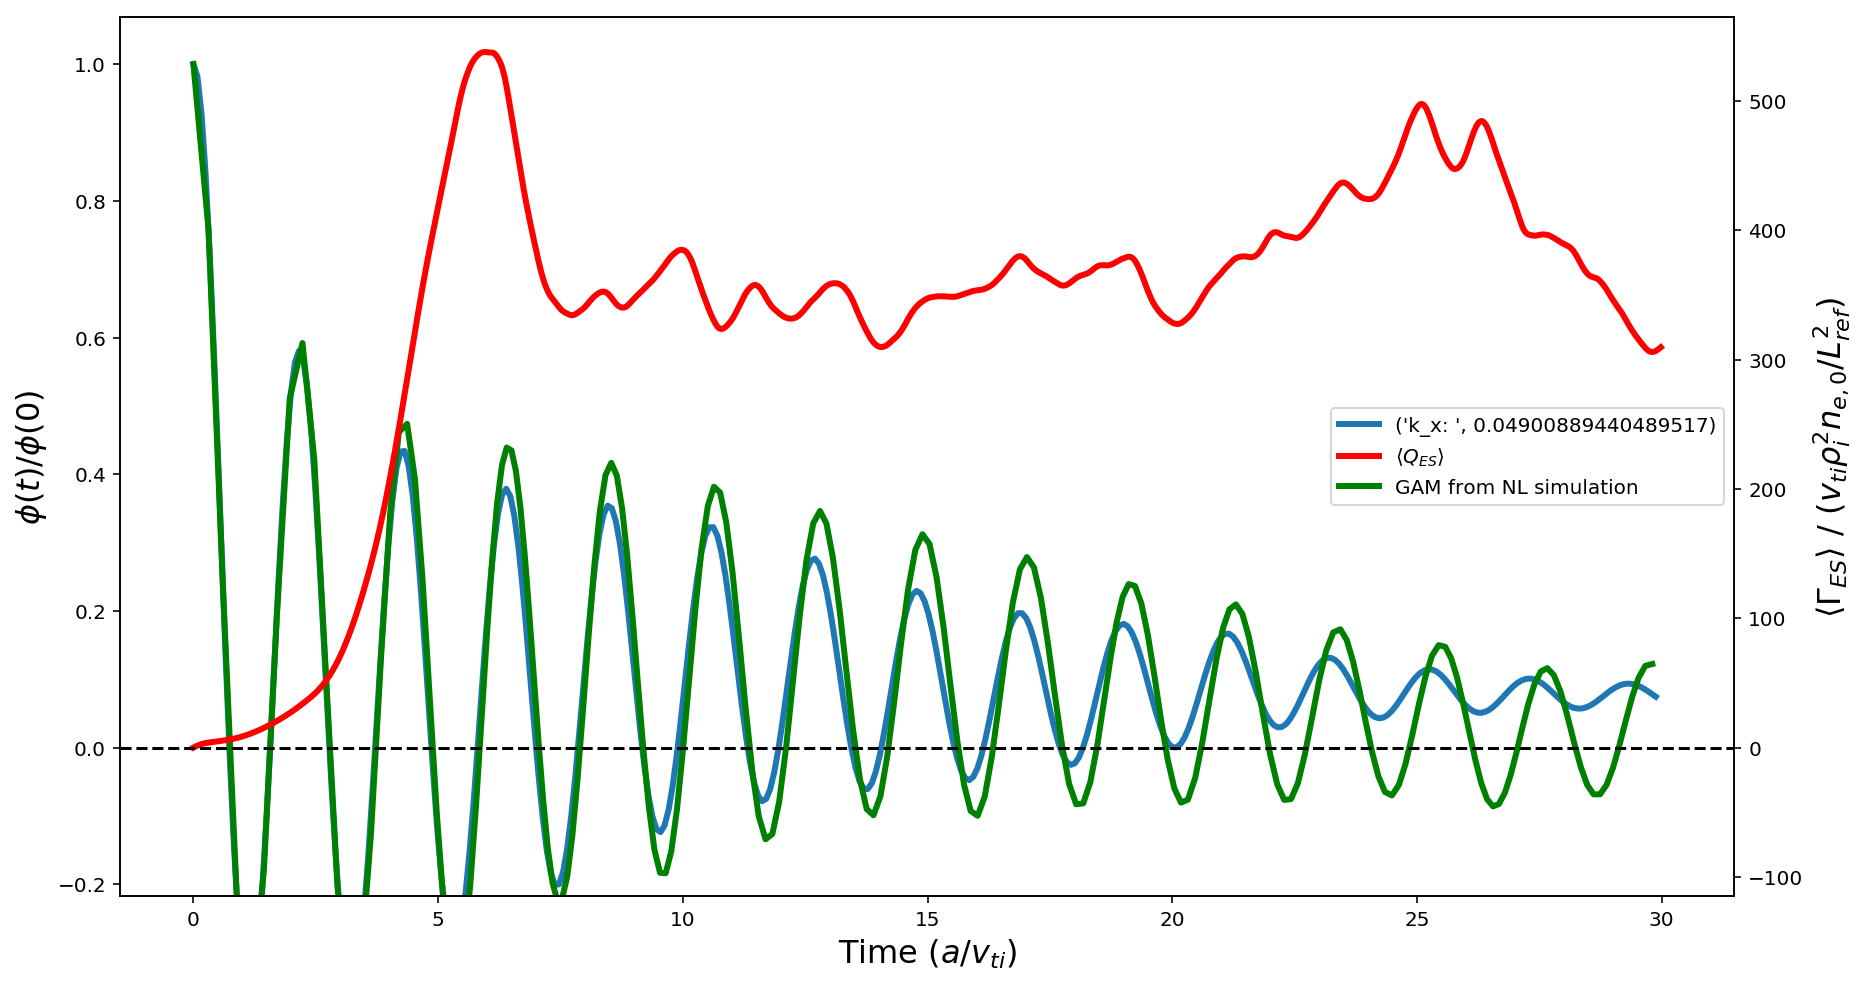

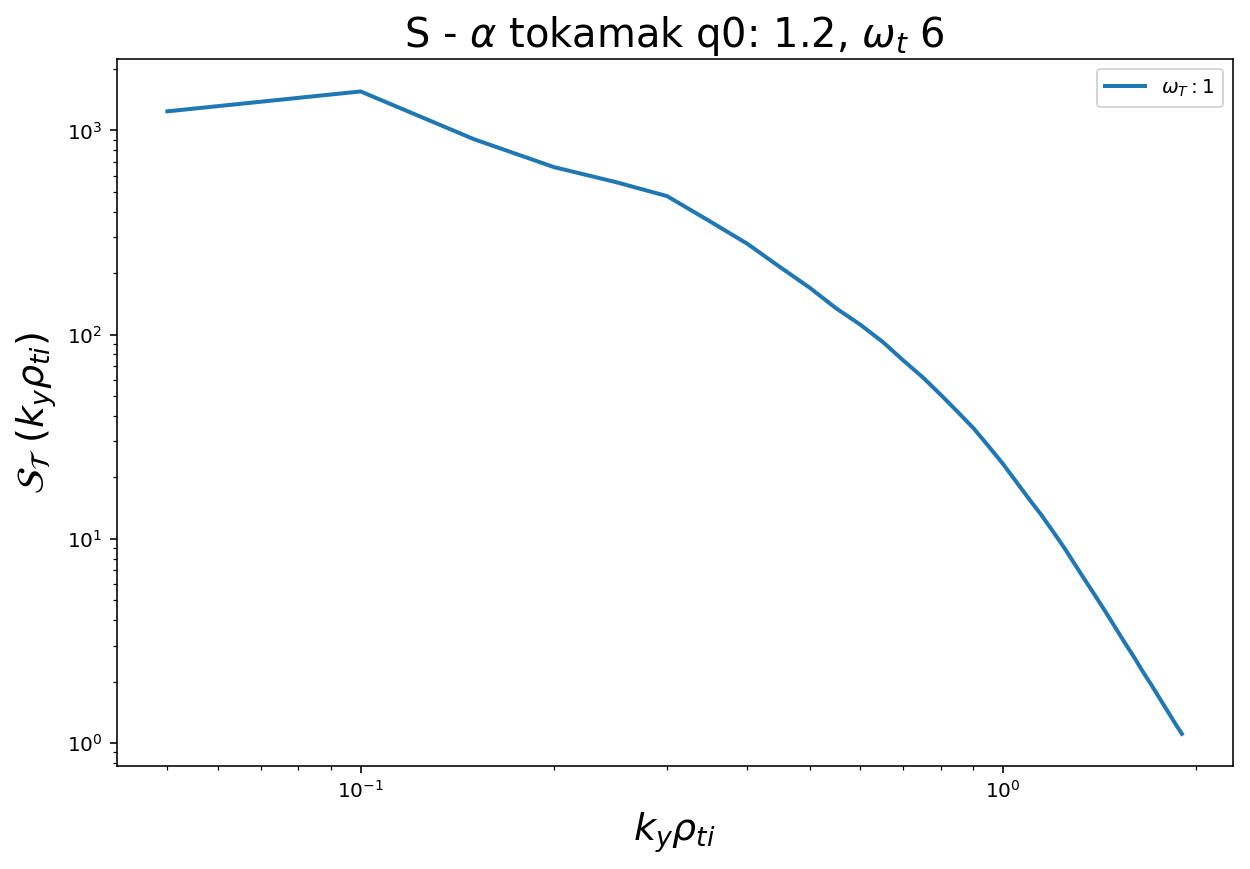

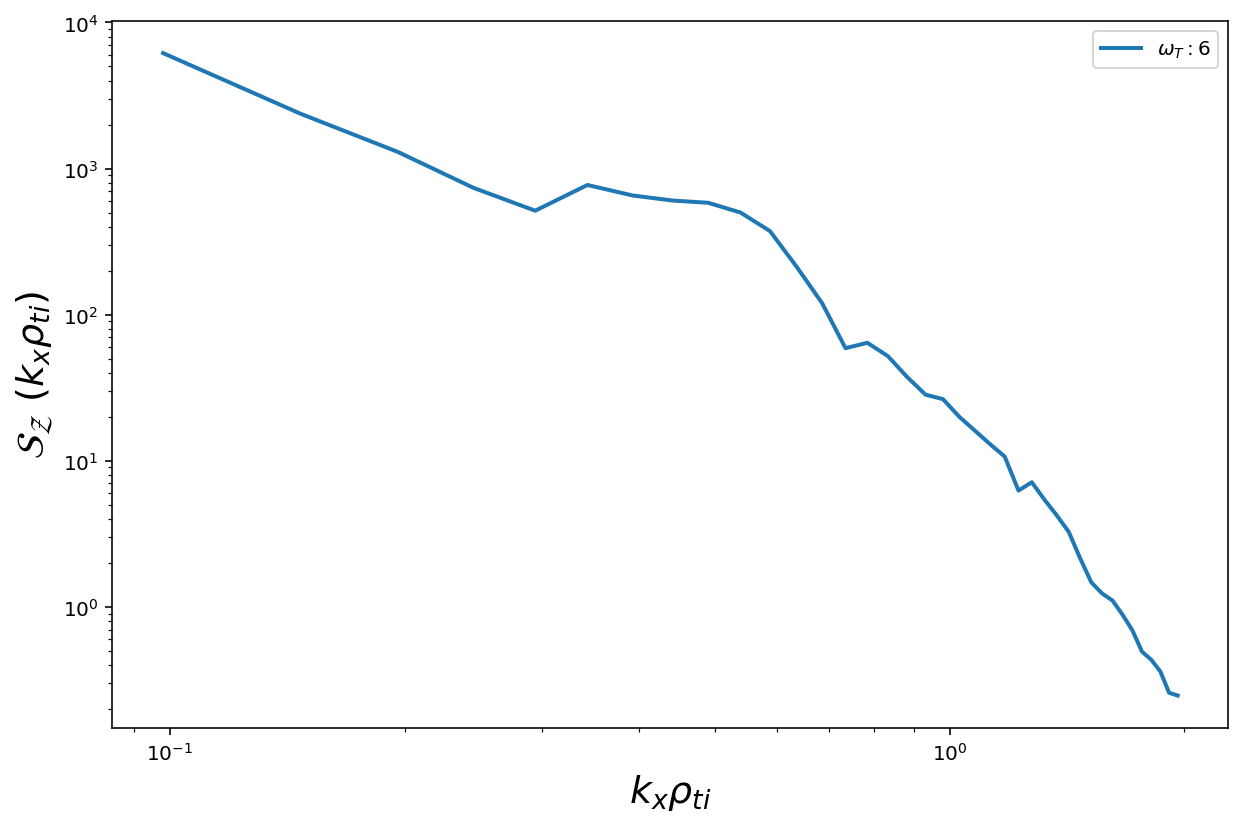

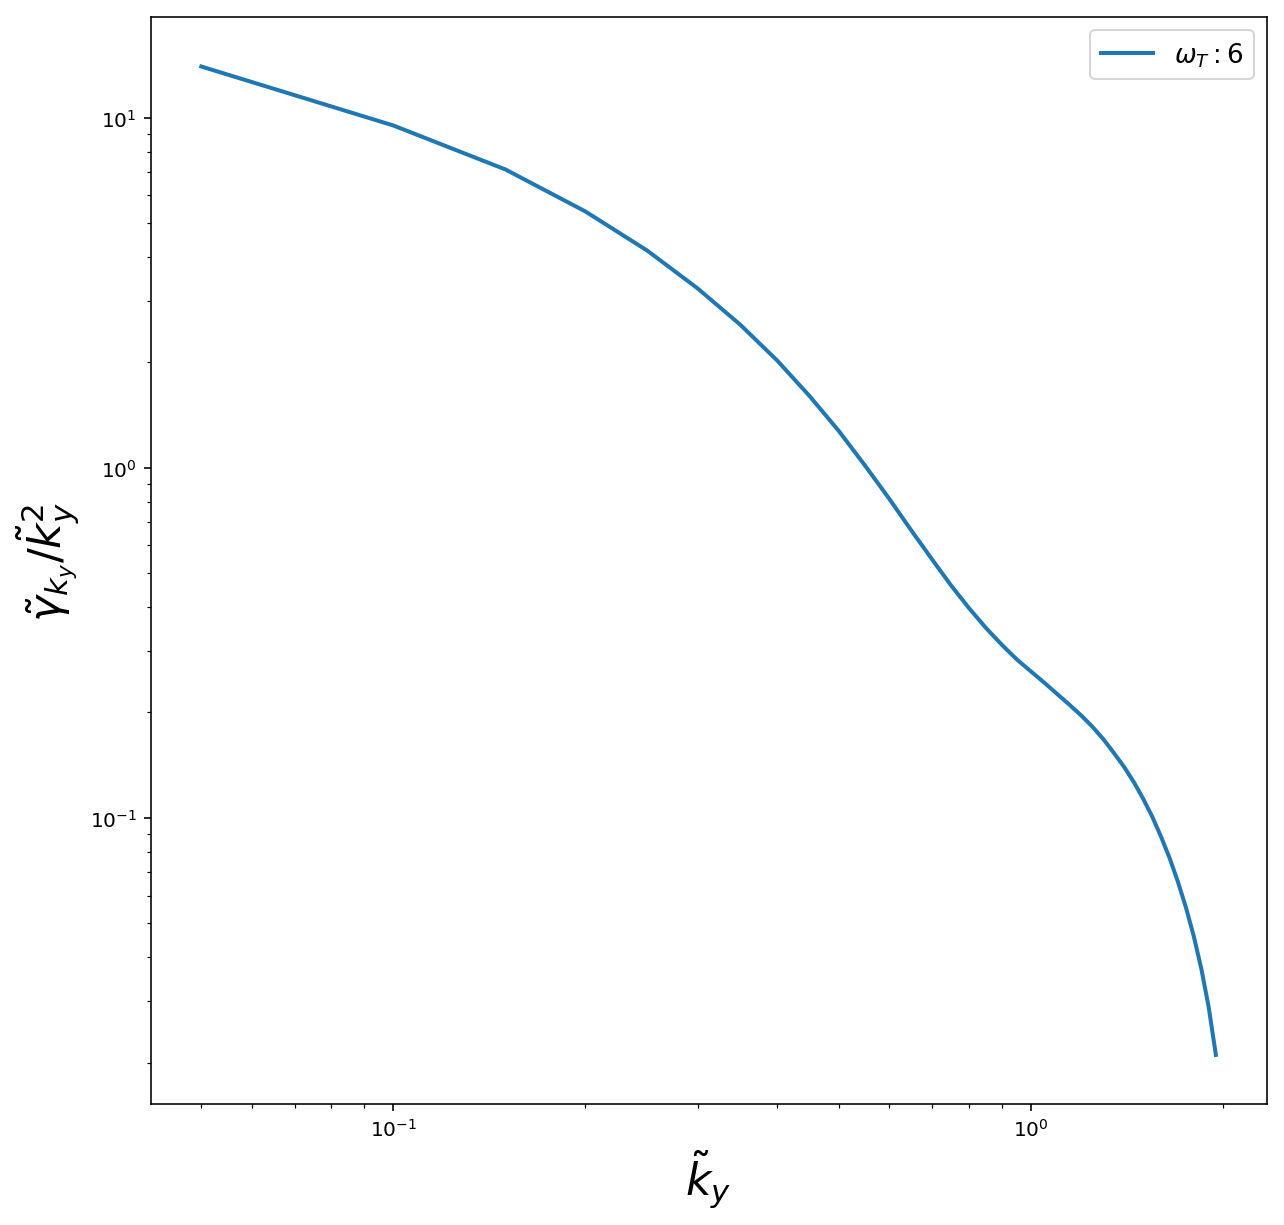

S-alpha geometry q0: 1.2 omt:6 

T total:    327.83169134300005
Z total:    596.954258692857
Sum g/k^2:   58.276461997947976
Tau:        0.2109439422506235


In [36]:
#333333333333333333333333333333333333333#
#3 STee maker & file loader            3#
#3 for S-alpha geometry, q0=1.2, omt=6 3#
#333333333333333333333333333333333333333#

# Load data
sa = [( pylab.loadtxt('q0-1.2/ITGa_NL/omt6/spectraions_act.dat',usecols = (0, 1)))][0]

#### Simulation parameters
nkx0 = 384
nky0 = 64
Lx = 128.205
kx_minimum = 0.049
ky_minimum = 0.05
t_final = 87.063935
t_sat = 7.74

Ts_sa12omt6 = 350         # Simulation temperature
TN_sa12omt6 = 2160        # Model reference temperature
rhos_sa12omt6 = 0.0027    # Simulation gyroradius
rhoN_sa12omt6 = 0.0018    # Model reference gyroradius

#### Geomertic parameters (Not very relevant)
q0       =    1.2
shat     =   0.78
trpeps   =   0.10
major_R  =    4.0

top = np.int(nkx0/2)

######################## Containers:
ky_sa12omt6 = np.zeros((top, nky0))
phisa = np.zeros((top, nky0))
St_sa12omt6 = np.zeros((nky0))
########################

# Extract ky and Phi for each omt
for n in range(0, top):
    lo = (0+(nky0*n))
    hi = (nky0+(nky0*n))
    ky_sa12omt6[n] = sa[lo:hi, 0]
    phisa[n] = sa[lo:hi, 1]
    np.add(St_sa12omt6, phisa[n]/ky_minimum, out=St_sa12omt6, where=True)

tzf_sa12omt6, tzf_sa12omt6_nl = diag('q0-1.2', plot=True, Lx=Lx, omt=6, mxtime=30)
hi = (nky0+(nky0*(top-1)))
kx_sa12omt6 = sa[hi:(hi+top), 0]
Sz_sa12omt6 = sa[hi:(hi+top), 1]/kx_minimum

############
kx_cut = (np.abs(kx_sa12omt6 - kx_minimum)).argmin()  # Implies that the minimum kx to compare comes from NL
kx_cut_max = (np.abs(kx_sa12omt6 - 2.0)).argmin()
kx_sa12omt6 = kx_sa12omt6[kx_cut+1:kx_cut_max]
Sz_sa12omt6 = Sz_sa12omt6[kx_cut+1:kx_cut_max]

ky_cut_max = (np.abs(ky_sa12omt6[1, 1:] - 2.0)).argmin()  
ky_sa12omt6 = ky_sa12omt6[1, 1:ky_cut_max]
St_sa12omt6 = St_sa12omt6[1:ky_cut_max]
############

#idx2 = (np.abs(ky_sa12omt6 - 1.0)).argmin()
#idx2f = idx2+35
#Y = St_sa12omt6[idx2:idx2f]
#X = ky_sa12omt6[1, idx2:idx2f]
#pars = mod.make_params(intercept=-1.42, slope=-1.96)
#out = mod.fit(Y, pars, x=X, nan_policy='propagate')
#print(out.fit_report(min_correl=0.25))

plt.figure(figsize=(10, 6.5))
plt.title("S - $\\alpha$ tokamak q0: 1.2, $\omega _{t}$ 6", fontsize=20)
plt.plot(ky_sa12omt6, St_sa12omt6, linewidth=2)  # Printing: the truncated range with normalisation
#plt.plot(X, out.init_fit, 'k--')
#plt.plot(X, out.best_fit, 'r-')
plt.legend(['$\omega_{T}: 1$', 'Init fit', 'Final fit'], fontsize=10)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{y}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{T}} \ (k_{y} \\rho_{ti})$',fontsize=19)
#plt.savefig('sa12_st_plot.eps', format='eps', dpi=1200)
plt.show()

plt.figure(figsize=(10, 6.5))
plt.plot(kx_sa12omt6, Sz_sa12omt6, linewidth=2)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{x}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{Z}} \ (k_{x} \\rho_{ti})$',fontsize=19)
plt.legend(['$\omega_{T}: 6$', '$\\tau_{ZF}$', 'Overshoot Ratio'], fontsize=10)
#plt.savefig('sa12_sz_plot.eps', format='eps', dpi=1200)
plt.show()

####### Load Linear simulations growth rates #######
datalist2 = [ pylab.loadtxt('./q0-1.2/ITGa_l/omt6.dat',usecols = (0, 2, 4, 5)) ][0]
ky_min = datalist2[:, 1]
gamma = datalist2[:, 2]
omega = datalist2[:, 3]

ky_cut2 = (np.abs(ky_min - 2.0)).argmin()
ky = ky_min[:ky_cut2]
g = gamma[:ky_cut2]

plt.figure(figsize=(10, 10))
plt.plot(ky, g/(ky**2), linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(['$\omega_{T}: 6$'], fontsize=13)
plt.xlabel('$\\tilde{k}_{y}$',fontsize=22)
plt.ylabel('$\\tilde{\gamma}_{k_{y}} / \\tilde{k}^{2}_{y}$',fontsize=22)
plt.show()

appT_sa12omt6 = np.nansum(g/(ky**2))
te_sa12omt6 = trapz(St_sa12omt6, x=ky_sa12omt6)
zet_sa12omt6 = trapz(Sz_sa12omt6, x=kx_sa12omt6)
#slope_sa12omt6, intercept = out.best_values.values()

print('S-alpha geometry q0: 1.2 omt:6 \n')
#print('S_T slope  ', slope_sa12omt6)
print('T total:   ', te_sa12omt6)
print('Z total:   ', zet_sa12omt6)
print('Sum g/k^2:  ', appT_sa12omt6)
print('Tau:       ', tzf_sa12omt6)

#333333333333333333333333333333333333333#
#3 STee maker & file loader            3#
#3 for S-alpha geometry, q0=1.2, omt=6 3#
#333333333333333333333333333333333333333#

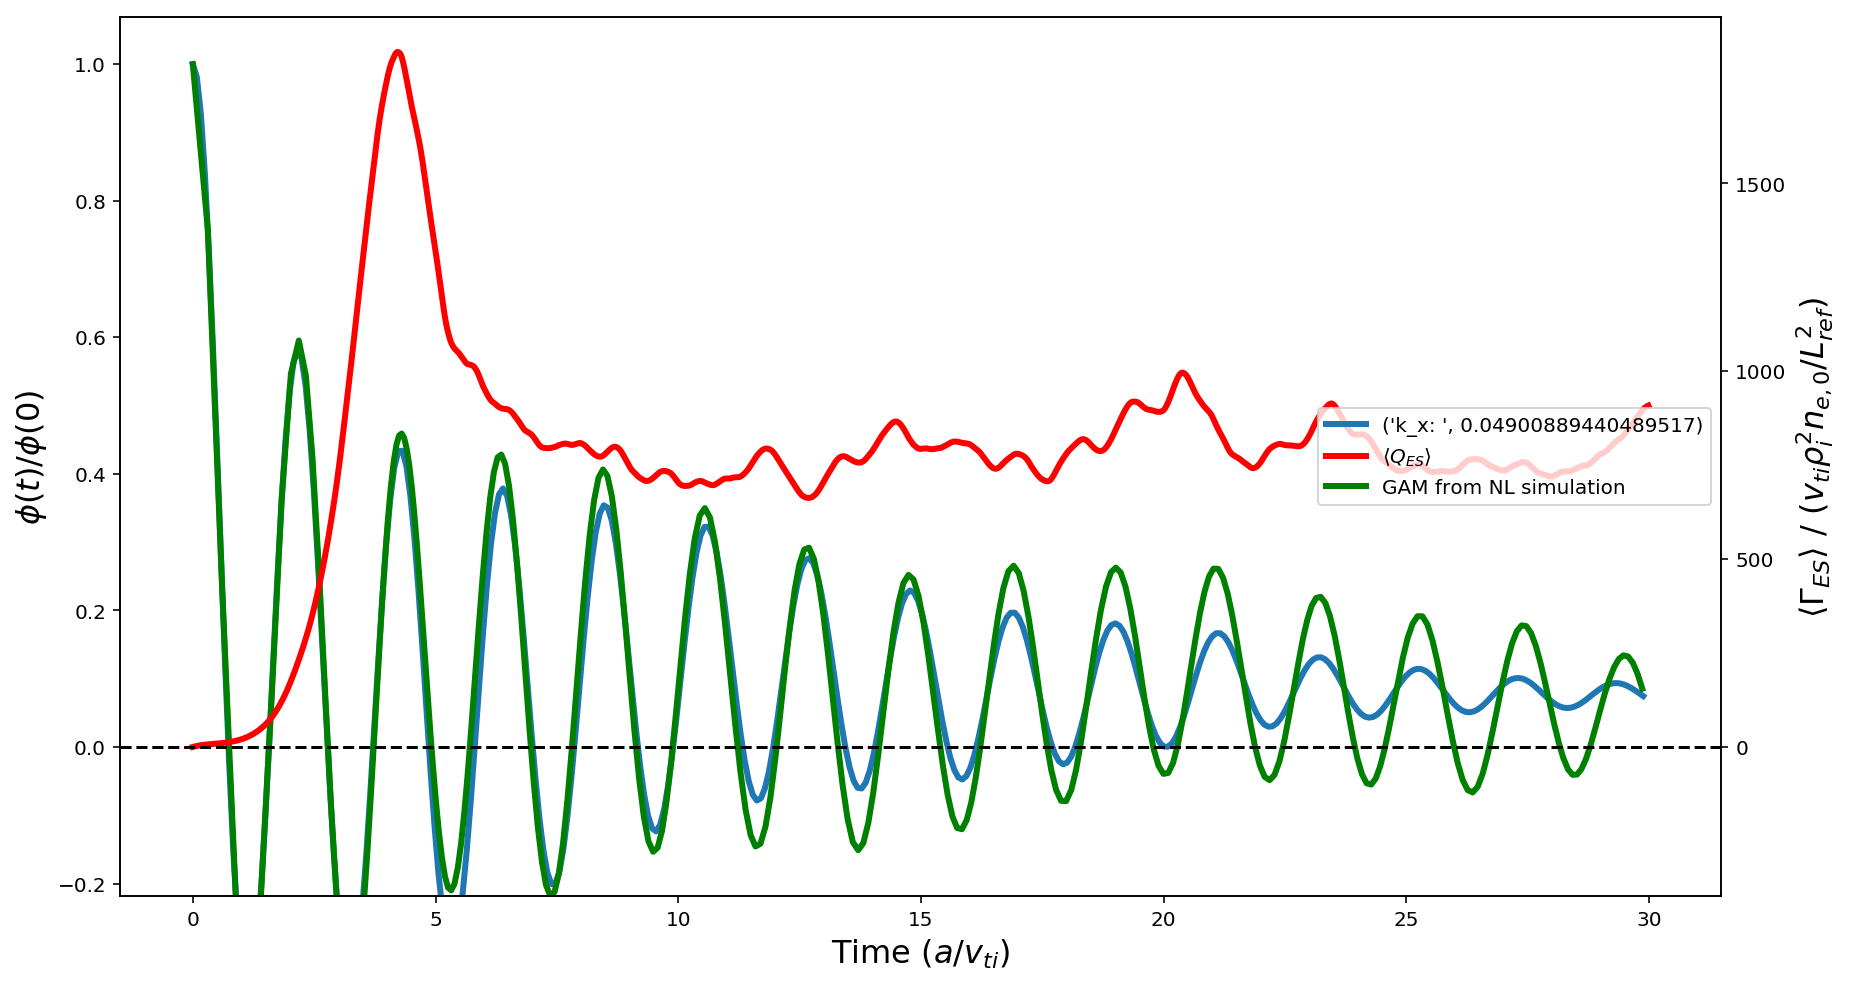

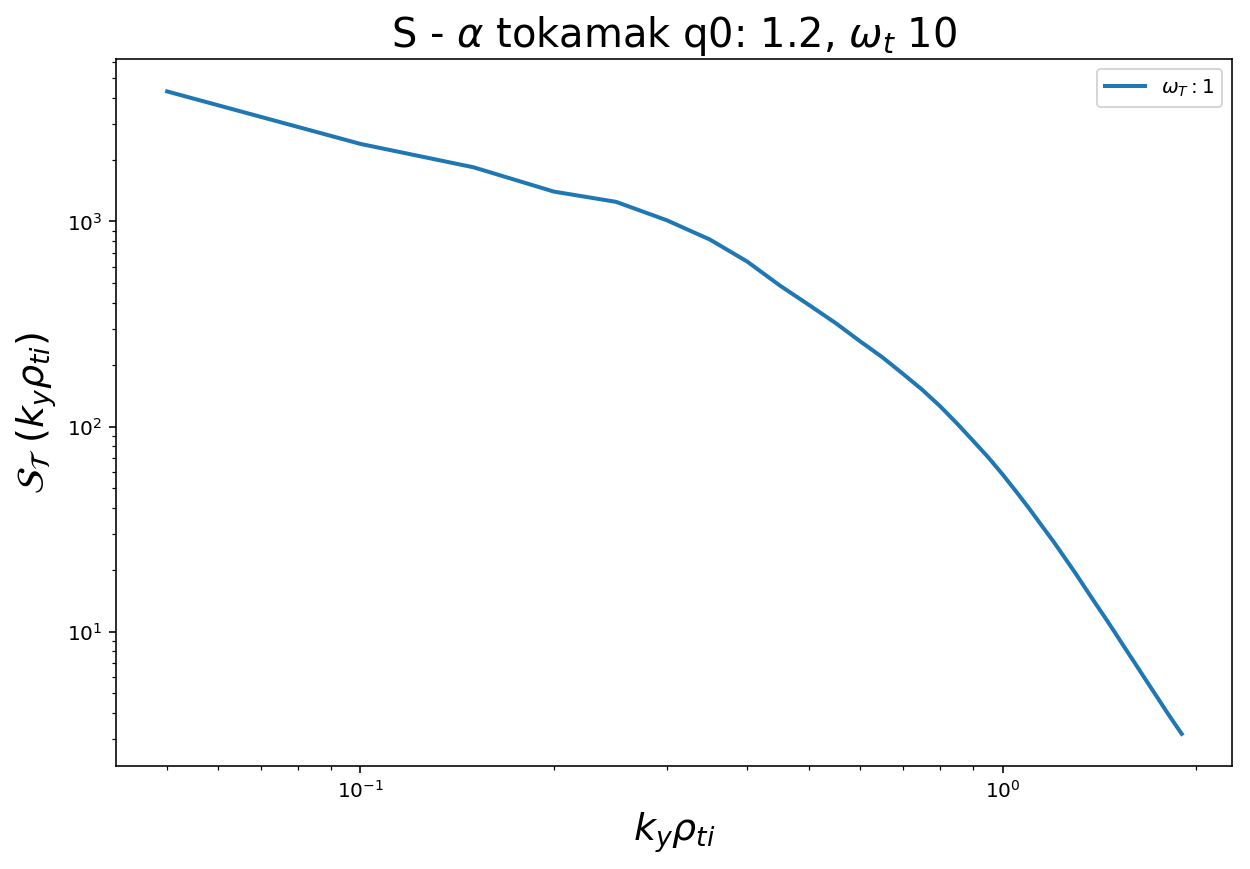

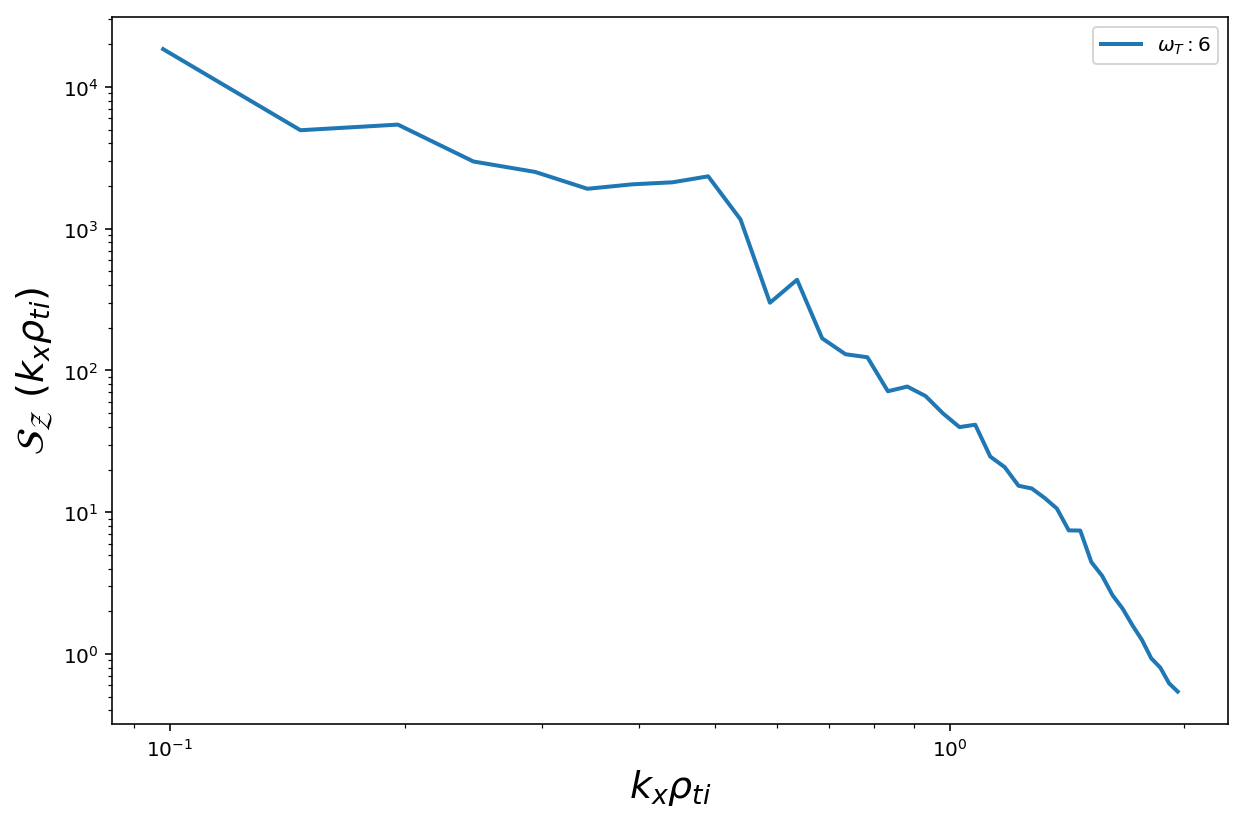

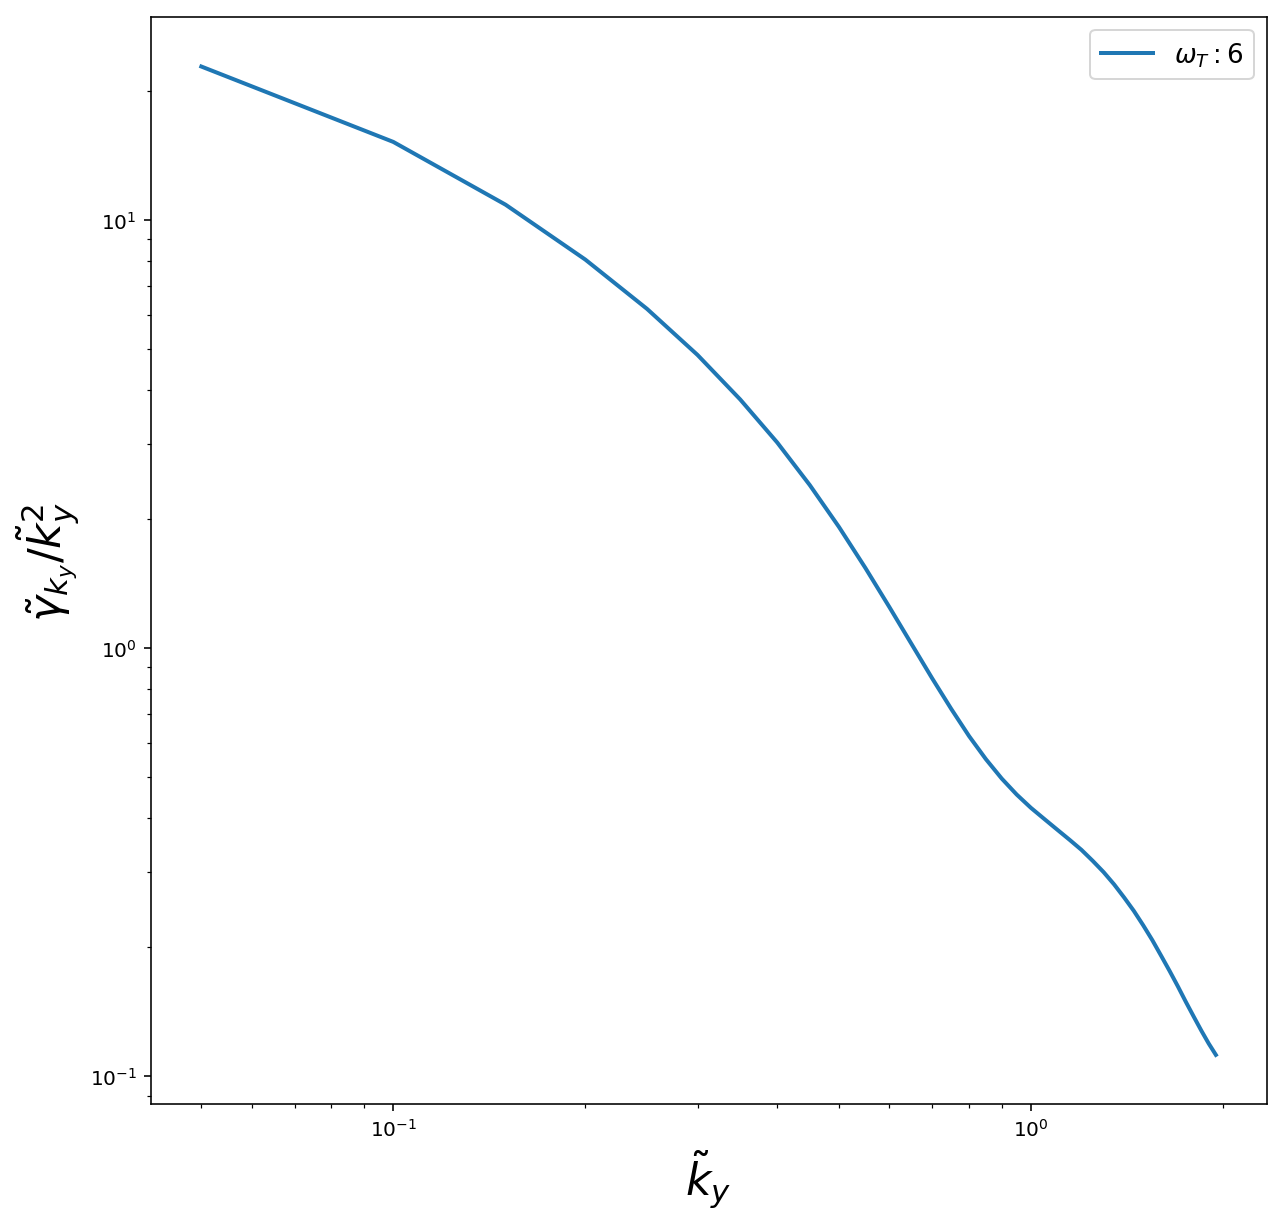

S-alpha geometry q0: 1.2 omt:10 

T total:    710.3753646249999
Z total:    1782.8628860153058
Sum g/k^2:   91.47492234743517
Tau:        0.2109439422506235


In [37]:
#4444444444444444444444444444444444444444#
#4 STee maker & file loader             4#
#4 for S-alpha geometry, q0=1.2, omt=10 4#
#4444444444444444444444444444444444444444#

# Load data
sa = [( pylab.loadtxt('q0-1.2/ITGa_NL/omt10/spectraions_act.dat',usecols = (0, 1)))][0]

#### Simulation parameters
nkx0 = 384
nky0 = 64
Lx = 128.205
kx_minimum = 0.049
ky_minimum = 0.05
t_final = 61.692025
t_sat = 7.5

Ts_sa12omt10 = 350         # Simulation temperature
TN_sa12omt10 = 2160        # Model reference temperature
rhos_sa12omt10 = 0.0027    # Simulation gyroradius
rhoN_sa12omt10 = 0.0018    # Model reference gyroradius

#### Geomertic parameters (Not very relevant)
q0       =    1.2
shat     =   0.78
trpeps   =   0.10
major_R  =    4.0

top = np.int(nkx0/2)

######################## Containers:
ky_sa12omt10 = np.zeros((top, nky0))
phisa = np.zeros((top, nky0))
St_sa12omt10 = np.zeros((nky0))
########################

# Extract ky and Phi for each omt
for n in range(0, top):
    lo = (0+(nky0*n))
    hi = (nky0+(nky0*n))
    ky_sa12omt10[n] = sa[lo:hi, 0]
    phisa[n] = sa[lo:hi, 1]
    np.add(St_sa12omt10, phisa[n]/ky_minimum, out=St_sa12omt10, where=True)

tzf_sa12omt10, tzf_sa12omt10_nl = diag('q0-1.2', plot=True, Lx=Lx, omt=10, mxtime=30)
hi = (nky0+(nky0*(top-1)))
kx_sa12omt10 = sa[hi:(hi+top), 0]
Sz_sa12omt10 = sa[hi:(hi+top), 1]/kx_minimum

#############
kx_cut = (np.abs(kx_sa12omt10 - kx_minimum)).argmin()  # Implies that the minimum kx to compare comes from NL
kx_cut_max = (np.abs(kx_sa12omt10 - 2.0)).argmin()
kx_sa12omt10 = kx_sa12omt10[kx_cut+1:kx_cut_max]
Sz_sa12omt10 = Sz_sa12omt10[kx_cut+1:kx_cut_max]

ky_cut_max = (np.abs(ky_sa12omt10[1, 1:] - 2.0)).argmin()
ky_sa12omt10 = ky_sa12omt10[1, 1:ky_cut_max]
St_sa12omt10 = St_sa12omt10[1:ky_cut_max]
#############

#idx2 = (np.abs(ky_sa12omt10 - 1.0)).argmin()
#idx2f = idx2+35
#Y = St_sa12omt10[idx2:idx2f]
#X = ky_sa12omt10[1, idx2:idx2f]
#pars = mod.make_params(intercept=-1.42, slope=-1.96)
#out = mod.fit(Y, pars, x=X, nan_policy='propagate')
#print(out.fit_report(min_correl=0.25))

plt.figure(figsize=(10, 6.5))
plt.title("S - $\\alpha$ tokamak q0: 1.2, $\omega _{t}$ 10", fontsize=20)
plt.plot(ky_sa12omt10, St_sa12omt10, linewidth=2)  # Printing: the truncated range with normalisation
#plt.plot(X, out.init_fit, 'k--')
#plt.plot(X, out.best_fit, 'r-')
plt.legend(['$\omega_{T}: 1$', 'Init fit', 'Final fit'], fontsize=10)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{y}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{T}} \ (k_{y} \\rho_{ti})$',fontsize=19)
#plt.savefig('sa12_st_plot.eps', format='eps', dpi=1200)
plt.show()

plt.figure(figsize=(10, 6.5))
plt.plot(kx_sa12omt10, Sz_sa12omt10, linewidth=2)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{x}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{Z}} \ (k_{x} \\rho_{ti})$',fontsize=19)
plt.legend(['$\omega_{T}: 6$', '$\\tau_{ZF}$', 'Overshoot Ratio'], fontsize=10)
#plt.savefig('sa12_sz_plot.eps', format='eps', dpi=1200)
plt.show()

####### Load Linear simulations growth rates #######
datalist2 = [ pylab.loadtxt('./q0-1.2/ITGa_l/omt10.dat',usecols = (0, 2, 4, 5)) ][0]
ky_min = datalist2[:, 1]
gamma = datalist2[:, 2]
omega = datalist2[:, 3]

ky_cut2 = (np.abs(ky_min - 2.0)).argmin()
ky = ky_min[:ky_cut2]
g = gamma[:ky_cut2]

plt.figure(figsize=(10, 10))
plt.plot(ky, g/(ky**2), linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(['$\omega_{T}: 6$'], fontsize=13)
plt.xlabel('$\\tilde{k}_{y}$',fontsize=22)
plt.ylabel('$\\tilde{\gamma}_{k_{y}} / \\tilde{k}^{2}_{y}$',fontsize=22)
plt.show()

appT_sa12omt10 = np.nansum(g/(ky**2))
te_sa12omt10 = trapz(St_sa12omt10, x=ky_sa12omt10)
zet_sa12omt10 = trapz(Sz_sa12omt10, x=kx_sa12omt10)
#slope_sa12omt10, intercept = out.best_values.values()

print('S-alpha geometry q0: 1.2 omt:10 \n')
#print('S_T slope  ', slope_sa12omt10)
print('T total:   ', te_sa12omt10)
print('Z total:   ', zet_sa12omt10)
print('Sum g/k^2:  ', appT_sa12omt10)
print('Tau:       ', tzf_sa12omt10)

#4444444444444444444444444444444444444444#
#4 STee maker & file loader             4#
#4 for S-alpha geometry, q0=1.2, omt=10 4#
#4444444444444444444444444444444444444444#

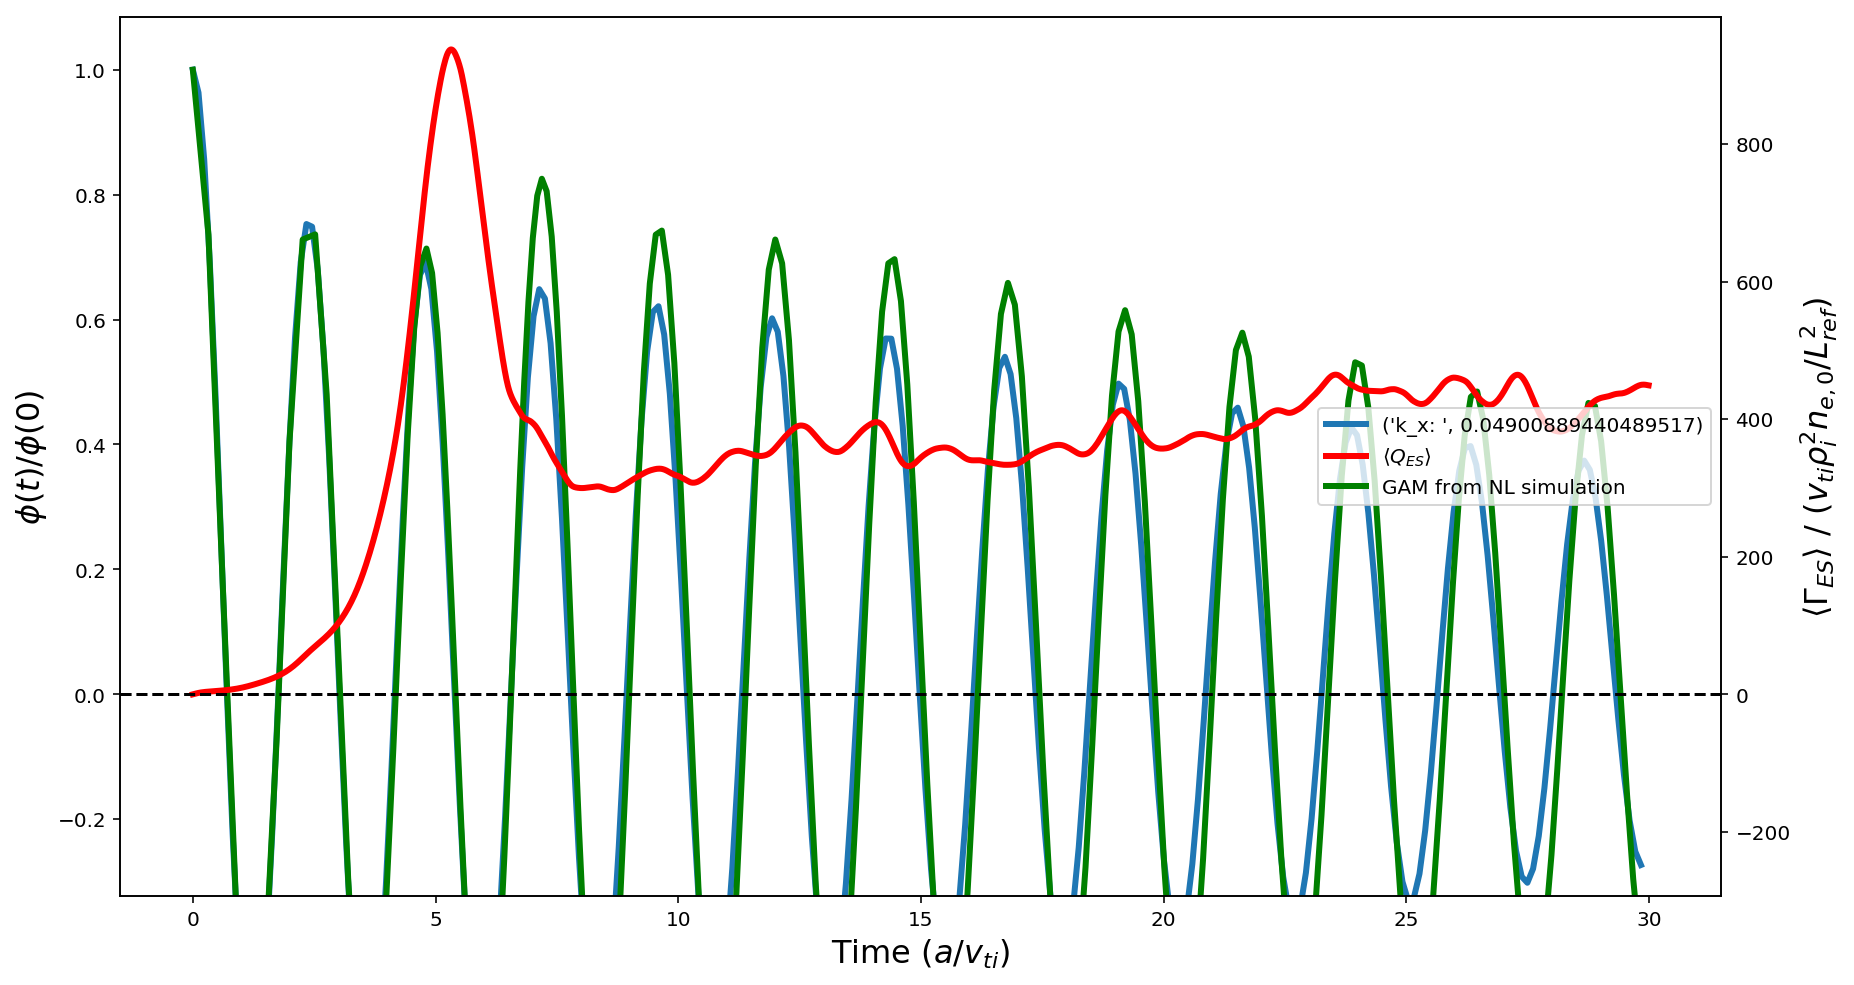

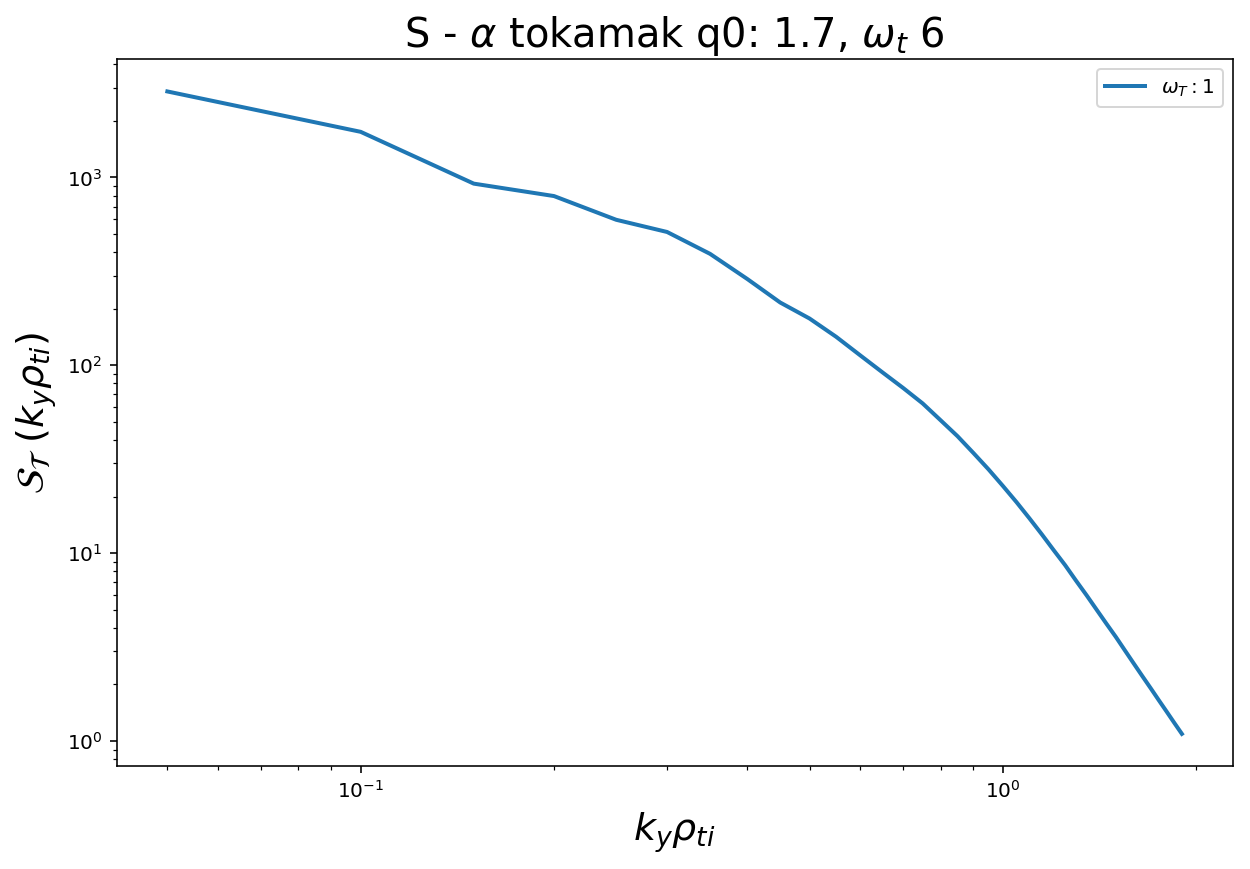

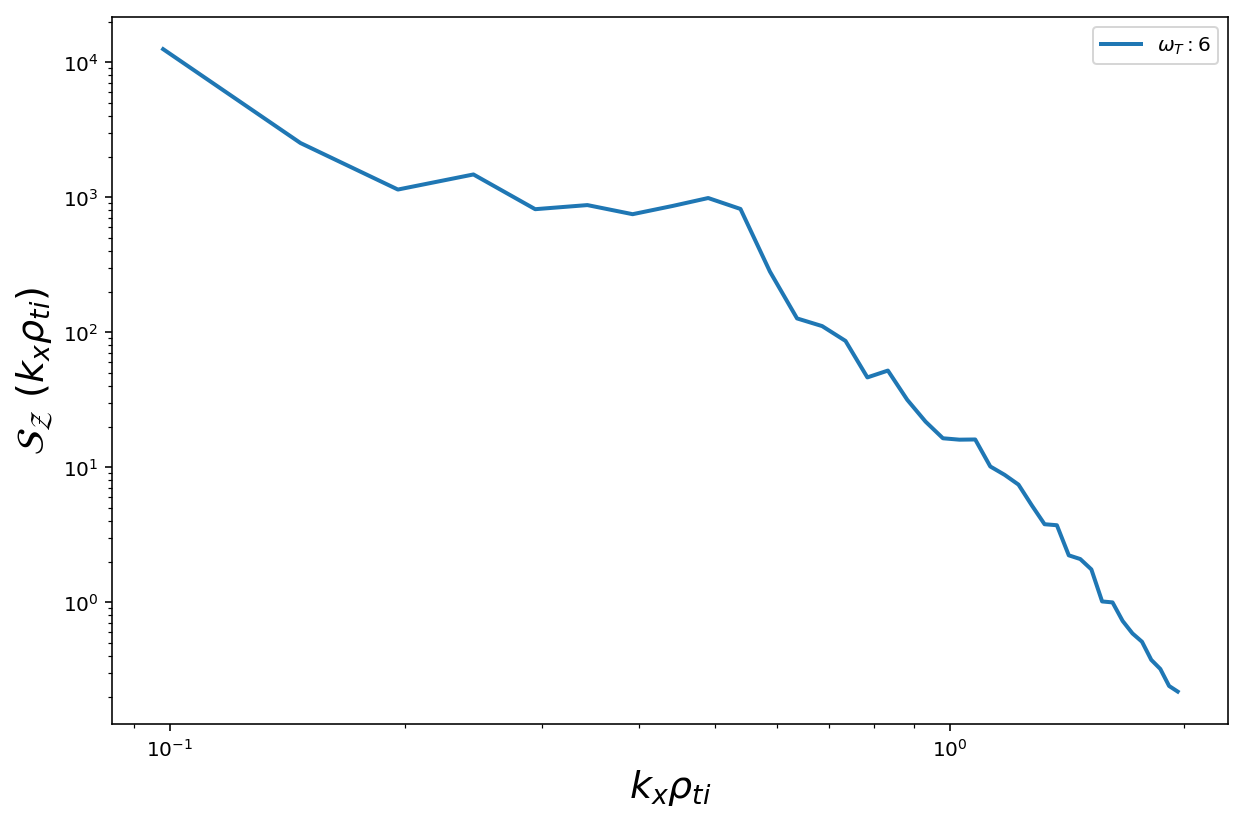

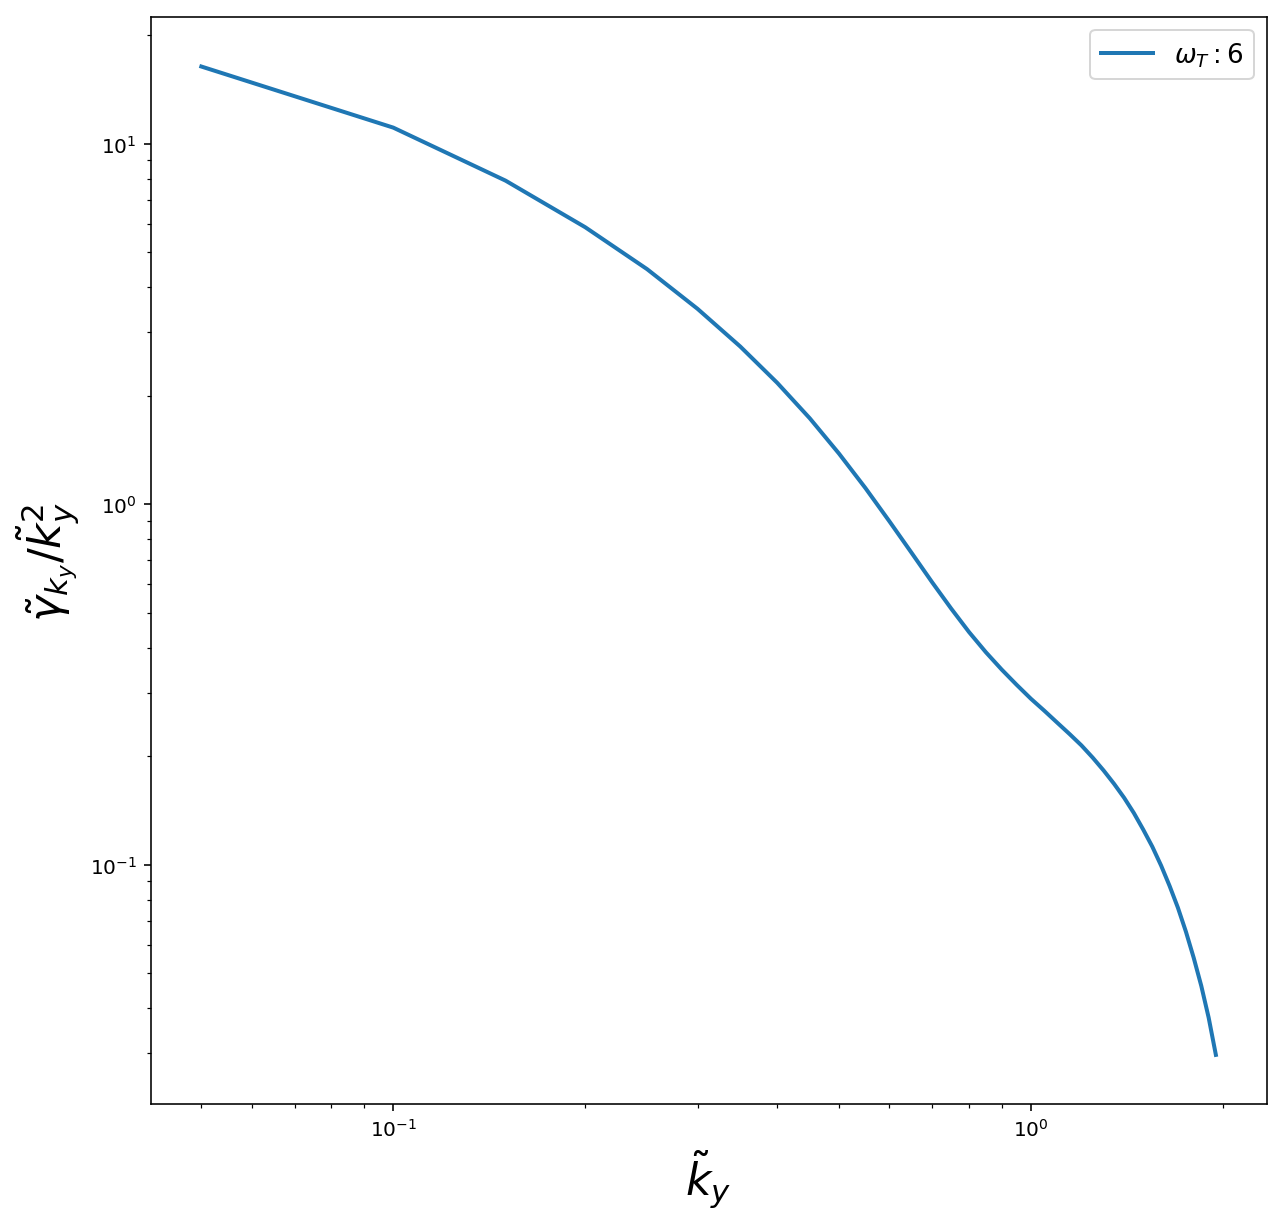

S-alpha geometry q0: 1.7 omt:6 

T total:    392.6208883645999
Z total:    850.3280952438776
Sum g/k^2:   65.49164175344184
Tau:        0.38318922944380956


In [38]:
###### 555555555555555555555555555555555555555#
#5 STee maker & file loader            5#
#5 for S-alpha geometry, q0=1.7, omt=6 5#
#555555555555555555555555555555555555555#

# Load data
sa = [( pylab.loadtxt('q0-1.7/ITGa_NL/omt6/spectraions_act.dat',usecols = (0, 1)))][0]

#### Simulation parameters
nkx0 = 384
nky0 = 64
Lx = 128.205
kx_minimum = 0.049
ky_minimum = 0.05
t_final = 78.809875
t_sat = 8.5

Ts_sa17omt6 = 350         # Simulation temperature
TN_sa17omt6 = 2160        # Model reference temperature
rhos_sa17omt6 = 0.0027    # Simulation gyroradius
rhoN_sa17omt6 = 0.0018    # Model reference gyroradius

#### Geomertic parameters (Not very relevant)
q0       =    1.7
shat     =   0.78
trpeps   =   0.10
major_R  =    4.0

top = np.int(nkx0/2)

######################## Containers:
ky_sa17omt6 = np.zeros((top, nky0))
phisa = np.zeros((top, nky0))
St_sa17omt6 = np.zeros((nky0))
########################

# Extract ky and Phi for each omt
for n in range(0, top):
    lo = (0+(nky0*n))
    hi = (nky0+(nky0*n))
    ky_sa17omt6[n] = sa[lo:hi, 0]
    phisa[n] = sa[lo:hi, 1]
    np.add(St_sa17omt6, phisa[n]/ky_minimum, out=St_sa17omt6, where=True)

tzf_sa17omt6, tzf_sa17omt6_nl = diag('q0-1.7', plot=True, Lx=Lx, omt=6, mxtime=30)
hi = (nky0+(nky0*(top-1)))
kx_sa17omt6 = sa[hi:(hi+top), 0]
Sz_sa17omt6 = sa[hi:(hi+top), 1]/kx_minimum

############
kx_cut = (np.abs(kx_sa17omt6 - kx_minimum)).argmin()  # Implies that the minimum kx to compare comes from NL
kx_cut_max = (np.abs(kx_sa17omt6 - 2.0)).argmin()
kx_sa17omt6 = kx_sa17omt6[kx_cut+1:kx_cut_max]
Sz_sa17omt6 = Sz_sa17omt6[kx_cut+1:kx_cut_max]

ky_cut_max = (np.abs(ky_sa17omt6[1, 1:] - 2.0)).argmin()
ky_sa17omt6 = ky_sa17omt6[1, 1:ky_cut_max]
St_sa17omt6 = St_sa17omt6[1:ky_cut_max]
############

#idx2 = (np.abs(ky_sa17omt6 - 1.0)).argmin()
#idx2f = idx2+35
#Y = St_sa17omt6[idx2:idx2f]
#X = ky_sa17omt6[1, idx2:idx2f]
#pars = mod.make_params(intercept=-1.42, slope=-1.96)
#out = mod.fit(Y, pars, x=X, nan_policy='propagate')
#print(out.fit_report(min_correl=0.25))

plt.figure(figsize=(10, 6.5))
plt.title("S - $\\alpha$ tokamak q0: 1.7, $\omega _{t}$ 6", fontsize=20)
plt.plot(ky_sa17omt6, St_sa17omt6, linewidth=2)  # Printing: the truncated range with normalisation
#plt.plot(X, out.init_fit, 'k--')
#plt.plot(X, out.best_fit, 'r-')
plt.legend(['$\omega_{T}: 1$', 'Init fit', 'Final fit'], fontsize=10)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{y}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{T}} \ (k_{y} \\rho_{ti})$',fontsize=19)
#plt.savefig('sa17_st_plot.eps', format='eps', dpi=1200)
plt.show()

plt.figure(figsize=(10, 6.5))
plt.plot(kx_sa17omt6, Sz_sa17omt6, linewidth=2)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{x}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{Z}} \ (k_{x} \\rho_{ti})$',fontsize=19)
plt.legend(['$\omega_{T}: 6$', '$\\tau_{ZF}$', 'Overshoot Ratio'], fontsize=10)
#plt.savefig('sa17_sz_plot.eps', format='eps', dpi=1200)
plt.show()

####### Load Linear simulations growth rates #######
datalist2 = [ pylab.loadtxt('./q0-1.7/ITGa_l/omt6.dat',usecols = (0, 2, 4, 5)) ][0]
ky_min = datalist2[:, 1]
gamma = datalist2[:, 2]
omega = datalist2[:, 3]

ky_cut2 = (np.abs(ky_min - 2.0)).argmin()
ky = ky_min[:ky_cut2]
g = gamma[:ky_cut2]

plt.figure(figsize=(10, 10))
plt.plot(ky, g/(ky**2), linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(['$\omega_{T}: 6$'], fontsize=13)
plt.xlabel('$\\tilde{k}_{y}$',fontsize=22)
plt.ylabel('$\\tilde{\gamma}_{k_{y}} / \\tilde{k}^{2}_{y}$',fontsize=22)
plt.show()

appT_sa17omt6 = np.nansum(g/(ky**2))
te_sa17omt6 = trapz(St_sa17omt6, x=ky_sa17omt6)
zet_sa17omt6 = trapz(Sz_sa17omt6, x=kx_sa17omt6)
#slope_sa17omt6, intercept = out.best_values.values()

print('S-alpha geometry q0: 1.7 omt:6 \n')
#print('S_T slope  ', slope_sa17omt6)
print('T total:   ', te_sa17omt6)
print('Z total:   ', zet_sa17omt6)
print('Sum g/k^2:  ', appT_sa17omt6)
print('Tau:       ', tzf_sa17omt6)

#555555555555555555555555555555555555555#
#5 STee maker & file loader            5#
#5 for S-alpha geometry, q0=1.7, omt=6 5#
#555555555555555555555555555555555555555#

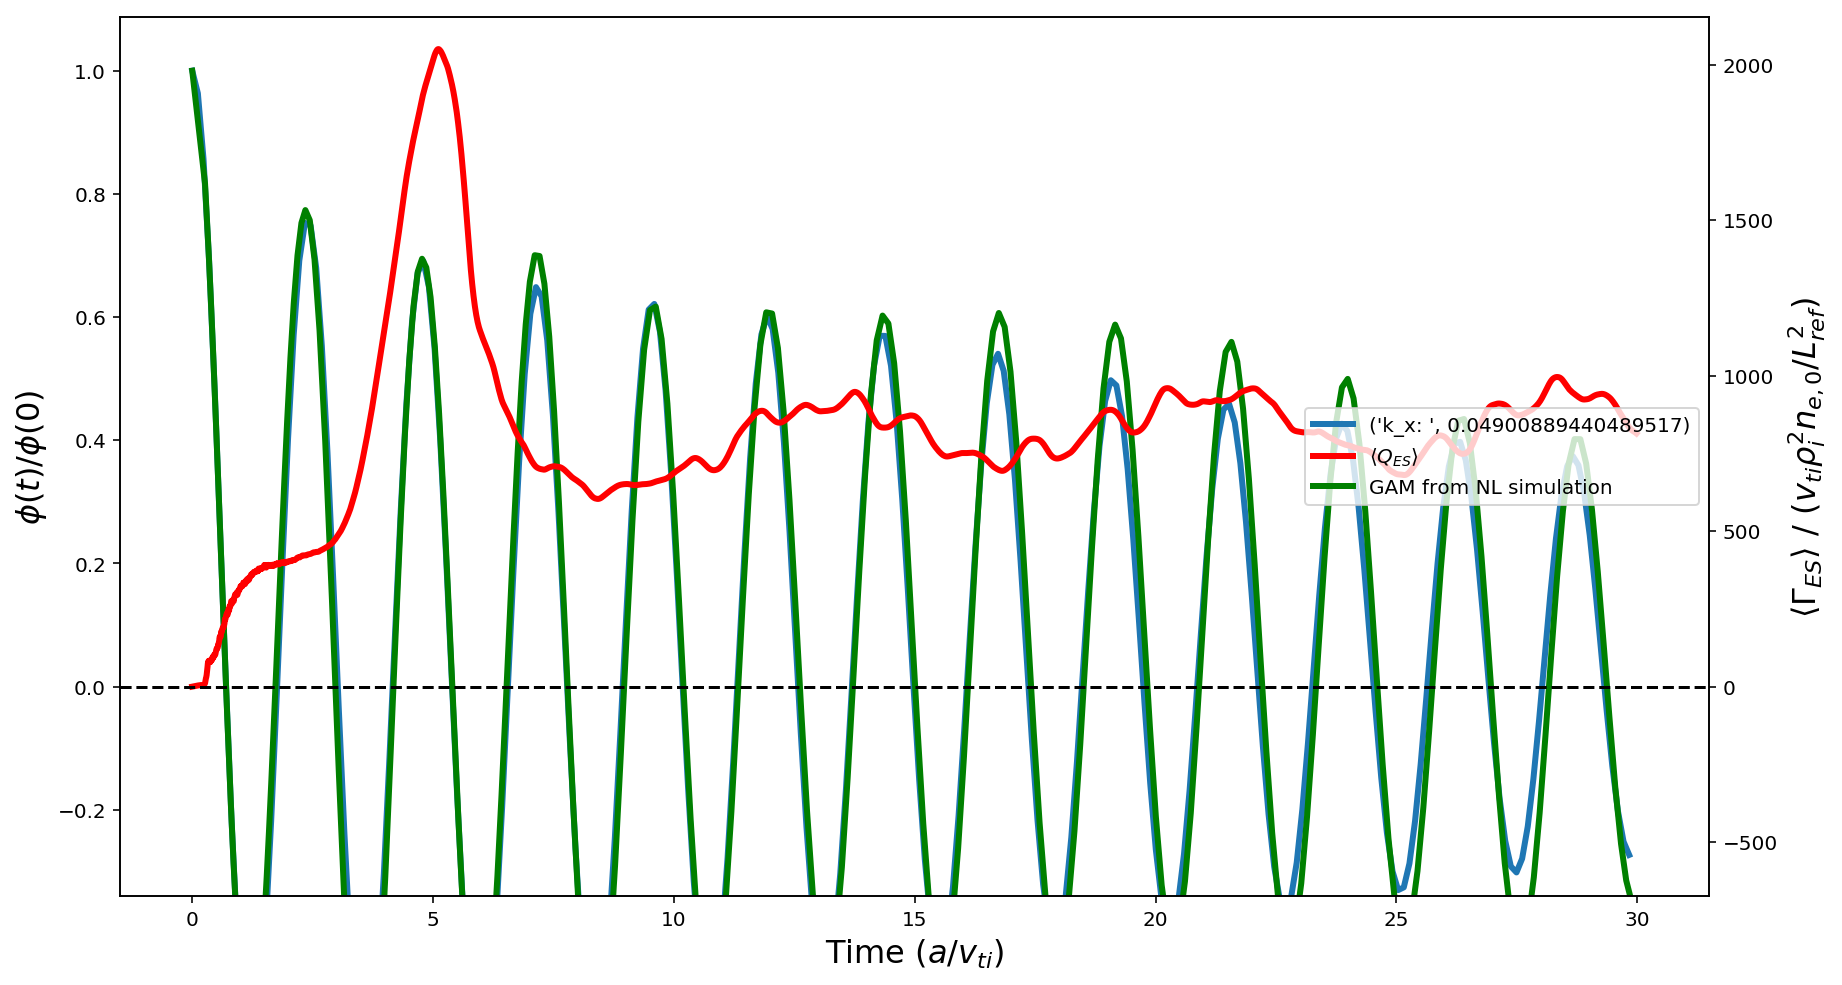

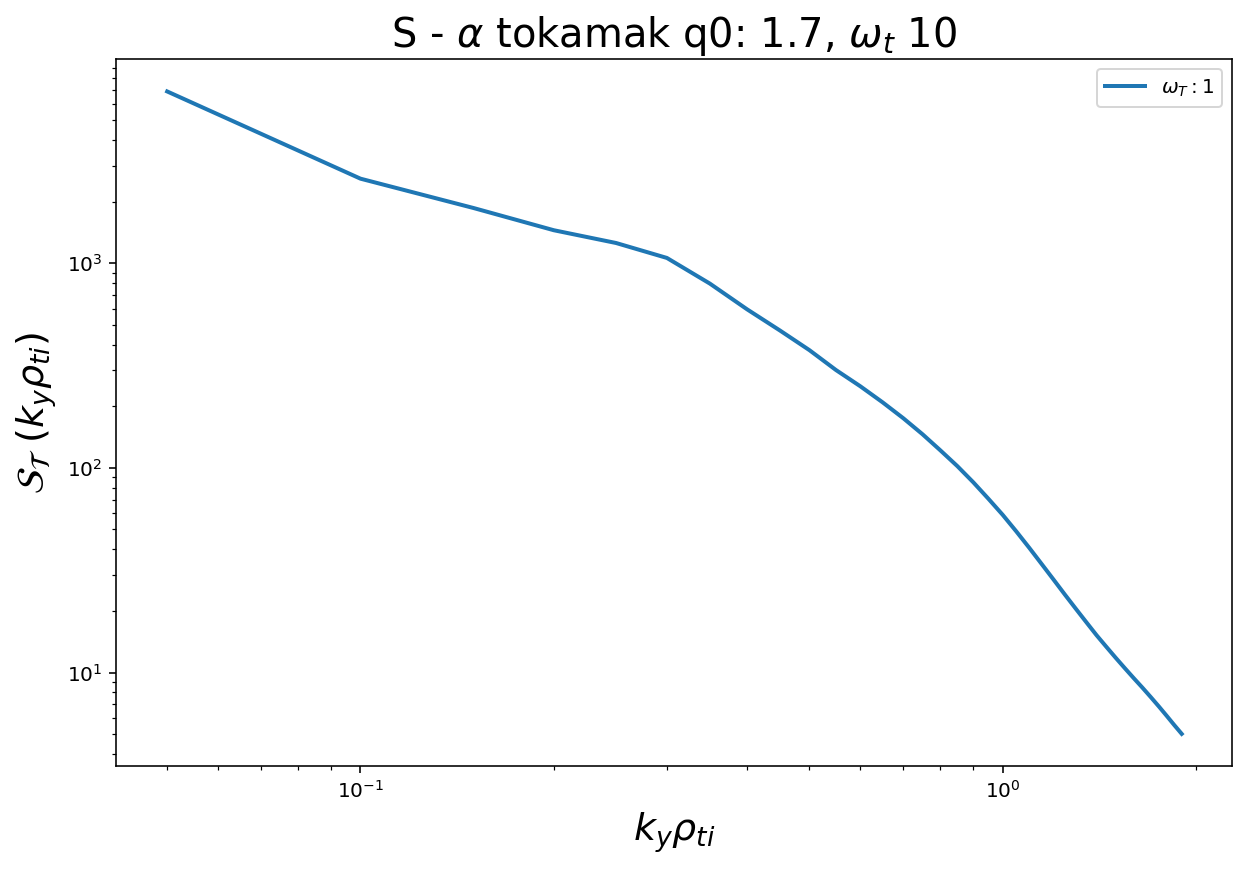

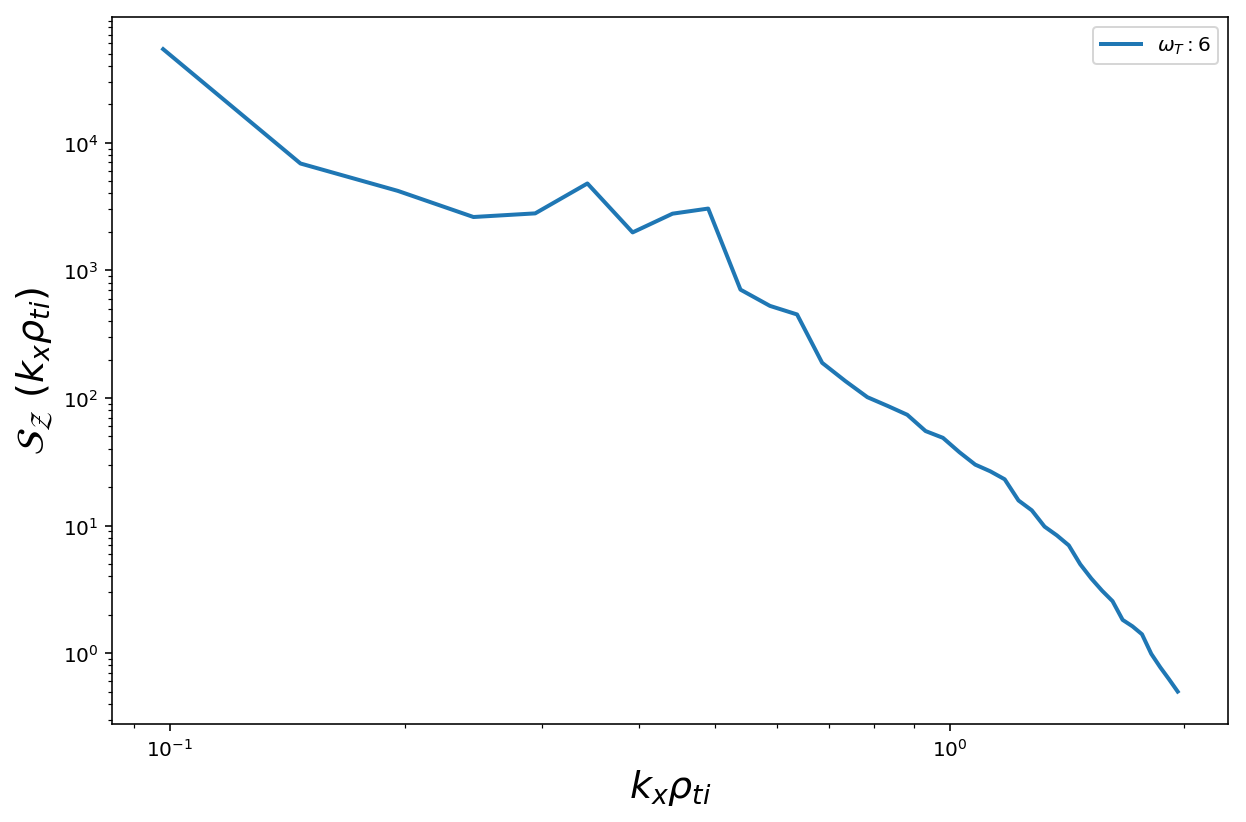

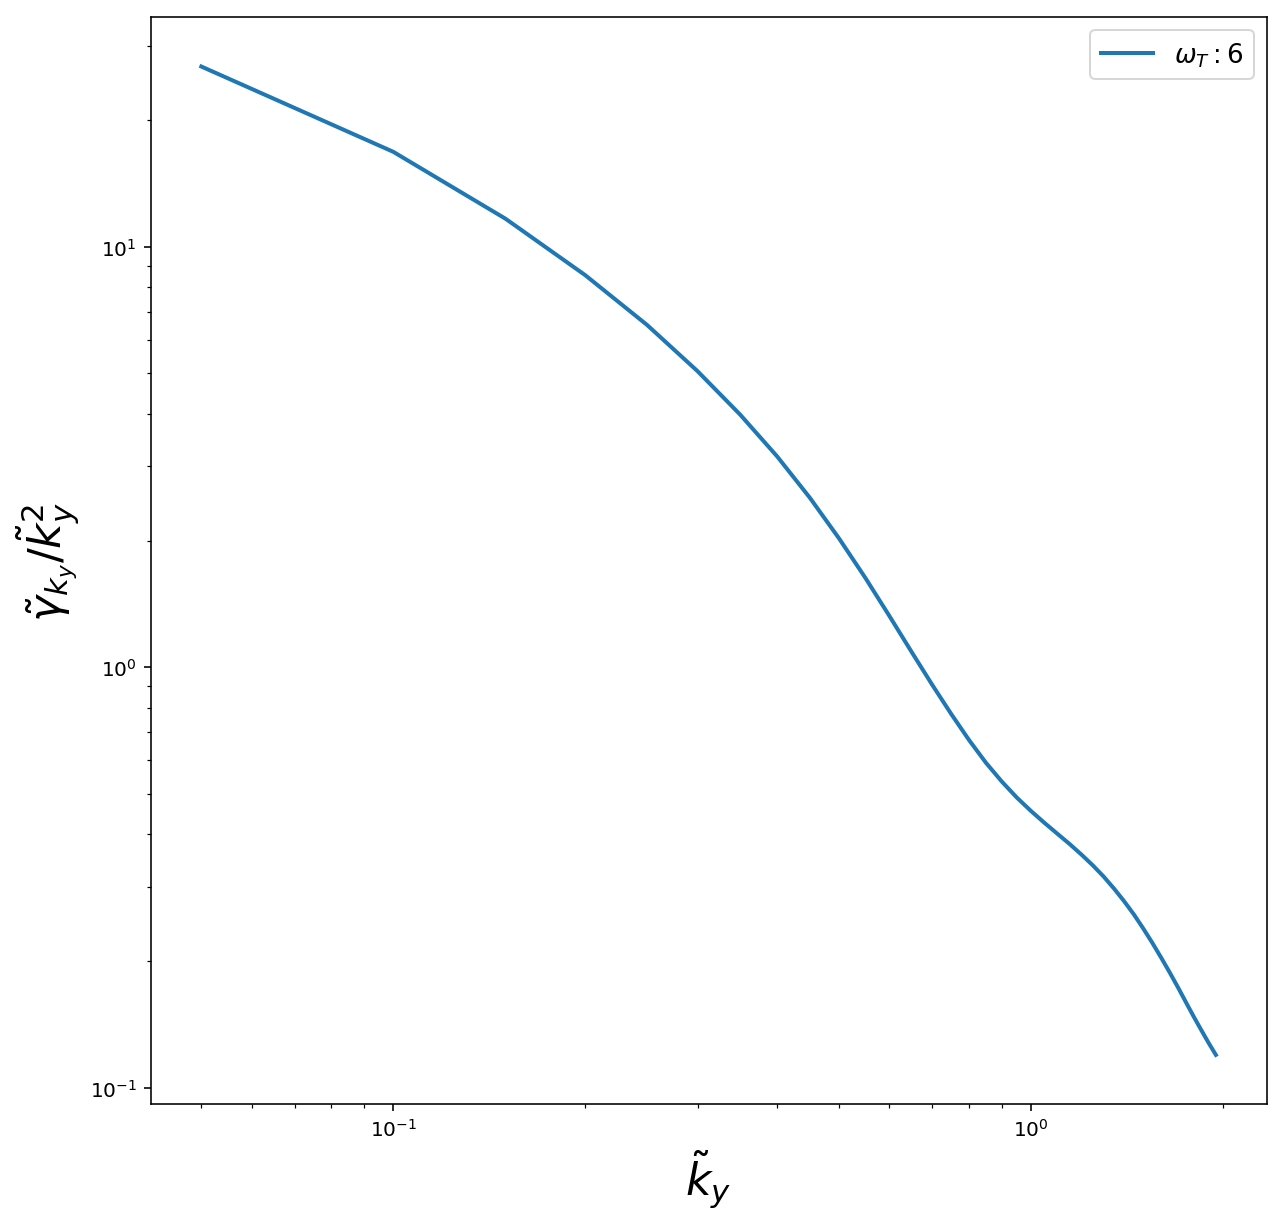

S-alpha geometry q0: 1.7 omt:6 

T total:    787.1141995099995
Z total:    2876.1930380571425
Sum g/k^2:   100.30050654261854
Tau:        0.38318922944380956


In [39]:
#6666666666666666666666666666666666666666#
#6 STee maker & file loader             6#
#6 for S-alpha geometry, q0=1.7, omt=10 6#
#6666666666666666666666666666666666666666#

# Load data
sa = [( pylab.loadtxt('q0-1.7/ITGa_NL/omt10/spectraions_act.dat',usecols = (0, 1)))][0]

#### Simulation parameters
nkx0 = 384
nky0 = 64
Lx = 128.205
kx_minimum = 0.049
ky_minimum = 0.05
t_final = 44.048209
t_sat = 8.5

Ts_sa17omt10 = 350         # Simulation temperature
TN_sa17omt10 = 2160        # Model reference temperature
rhos_sa17omt10 = 0.0027    # Simulation gyroradius
rhoN_sa17omt10 = 0.0018    # Model reference gyroradius

#### Geomertic parameters (Not very relevant)
q0       =    1.7
shat     =   0.78
trpeps   =   0.10
major_R  =    4.0

top = np.int(nkx0/2)

######################## Containers:
ky_sa17omt10 = np.zeros((top, nky0))
phisa = np.zeros((top, nky0))
St_sa17omt10 = np.zeros((nky0))
########################

# Extract ky and Phi for each omt
for n in range(0, top):
    lo = (0+(nky0*n))
    hi = (nky0+(nky0*n))
    ky_sa17omt10[n] = sa[lo:hi, 0]
    phisa[n] = sa[lo:hi, 1]
    np.add(St_sa17omt10, phisa[n]/ky_minimum, out=St_sa17omt10, where=True)

tzf_sa17omt10, tzf_sa17omt10_nl = diag('q0-1.7', plot=True, Lx=Lx, omt=10, mxtime=30)
hi = (nky0+(nky0*(top-1)))
kx_sa17omt10 = sa[hi:(hi+top), 0]
Sz_sa17omt10 = sa[hi:(hi+top), 1]/kx_minimum

############
kx_cut = (np.abs(kx_sa17omt10 - kx_minimum)).argmin()  # Implies that the minimum kx to compare comes from NL
kx_cut_max = (np.abs(kx_sa17omt10 - 2.0)).argmin()
kx_sa17omt10 = kx_sa17omt10[kx_cut+1:kx_cut_max]
Sz_sa17omt10 = Sz_sa17omt10[kx_cut+1:kx_cut_max]

ky_cut_max = (np.abs(ky_sa17omt10[1, 1:] - 2.0)).argmin()
ky_sa17omt10 = ky_sa17omt10[1, 1:ky_cut_max]
St_sa17omt10 = St_sa17omt10[1:ky_cut_max]
############

#idx2 = (np.abs(ky_sa17omt10 - 1.0)).argmin()
#idx2f = idx2+35
#Y = St_sa17omt10[idx2:idx2f]
#X = ky_sa17omt10[1, idx2:idx2f]
#pars = mod.make_params(intercept=-1.42, slope=-1.96)
#out = mod.fit(Y, pars, x=X, nan_policy='propagate')
#print(out.fit_report(min_correl=0.25))

plt.figure(figsize=(10, 6.5))
plt.title("S - $\\alpha$ tokamak q0: 1.7, $\omega _{t}$ 10", fontsize=20)
plt.plot(ky_sa17omt10, St_sa17omt10, linewidth=2)  # Printing: the truncated range with normalisation
#plt.plot(X, out.init_fit, 'k--')
#plt.plot(X, out.best_fit, 'r-')
plt.legend(['$\omega_{T}: 1$', 'Init fit', 'Final fit'], fontsize=10)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{y}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{T}} \ (k_{y} \\rho_{ti})$',fontsize=19)
#plt.savefig('sa17_st_plot.eps', format='eps', dpi=1200)
plt.show()

plt.figure(figsize=(10, 6.5))
plt.plot(kx_sa17omt10, Sz_sa17omt10, linewidth=2)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{x}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{Z}} \ (k_{x} \\rho_{ti})$',fontsize=19)
plt.legend(['$\omega_{T}: 6$', '$\\tau_{ZF}$', 'Overshoot Ratio'], fontsize=10)
#plt.savefig('sa17_sz_plot.eps', format='eps', dpi=1200)
plt.show()

####### Load Linear simulations growth rates #######
datalist2 = [ pylab.loadtxt('./q0-1.7/ITGa_l/omt10.dat',usecols = (0, 2, 4, 5)) ][0]
ky_min = datalist2[:, 1]
gamma = datalist2[:, 2]
omega = datalist2[:, 3]

ky_cut2 = (np.abs(ky_min - 2.0)).argmin()
ky = ky_min[:ky_cut2]
g = gamma[:ky_cut2]

plt.figure(figsize=(10, 10))
plt.plot(ky, g/(ky**2), linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(['$\omega_{T}: 6$'], fontsize=13)
plt.xlabel('$\\tilde{k}_{y}$',fontsize=22)
plt.ylabel('$\\tilde{\gamma}_{k_{y}} / \\tilde{k}^{2}_{y}$',fontsize=22)
plt.show()

appT_sa17omt10 = np.nansum(g/(ky**2))
te_sa17omt10 = trapz(St_sa17omt10, x=ky_sa17omt10)
zet_sa17omt10 = trapz(Sz_sa17omt10, x=kx_sa17omt10)
#slope_sa17omt10, intercept = out.best_values.values()

print('S-alpha geometry q0: 1.7 omt:6 \n')
#print('S_T slope  ', slope_sa17omt10)
print('T total:   ', te_sa17omt10)
print('Z total:   ', zet_sa17omt10)
print('Sum g/k^2:  ', appT_sa17omt10)
print('Tau:       ', tzf_sa17omt10)

#6666666666666666666666666666666666666666#
#6 STee maker & file loader             6#
#6 for S-alpha geometry, q0=1.7, omt=10 6#
#6666666666666666666666666666666666666666#

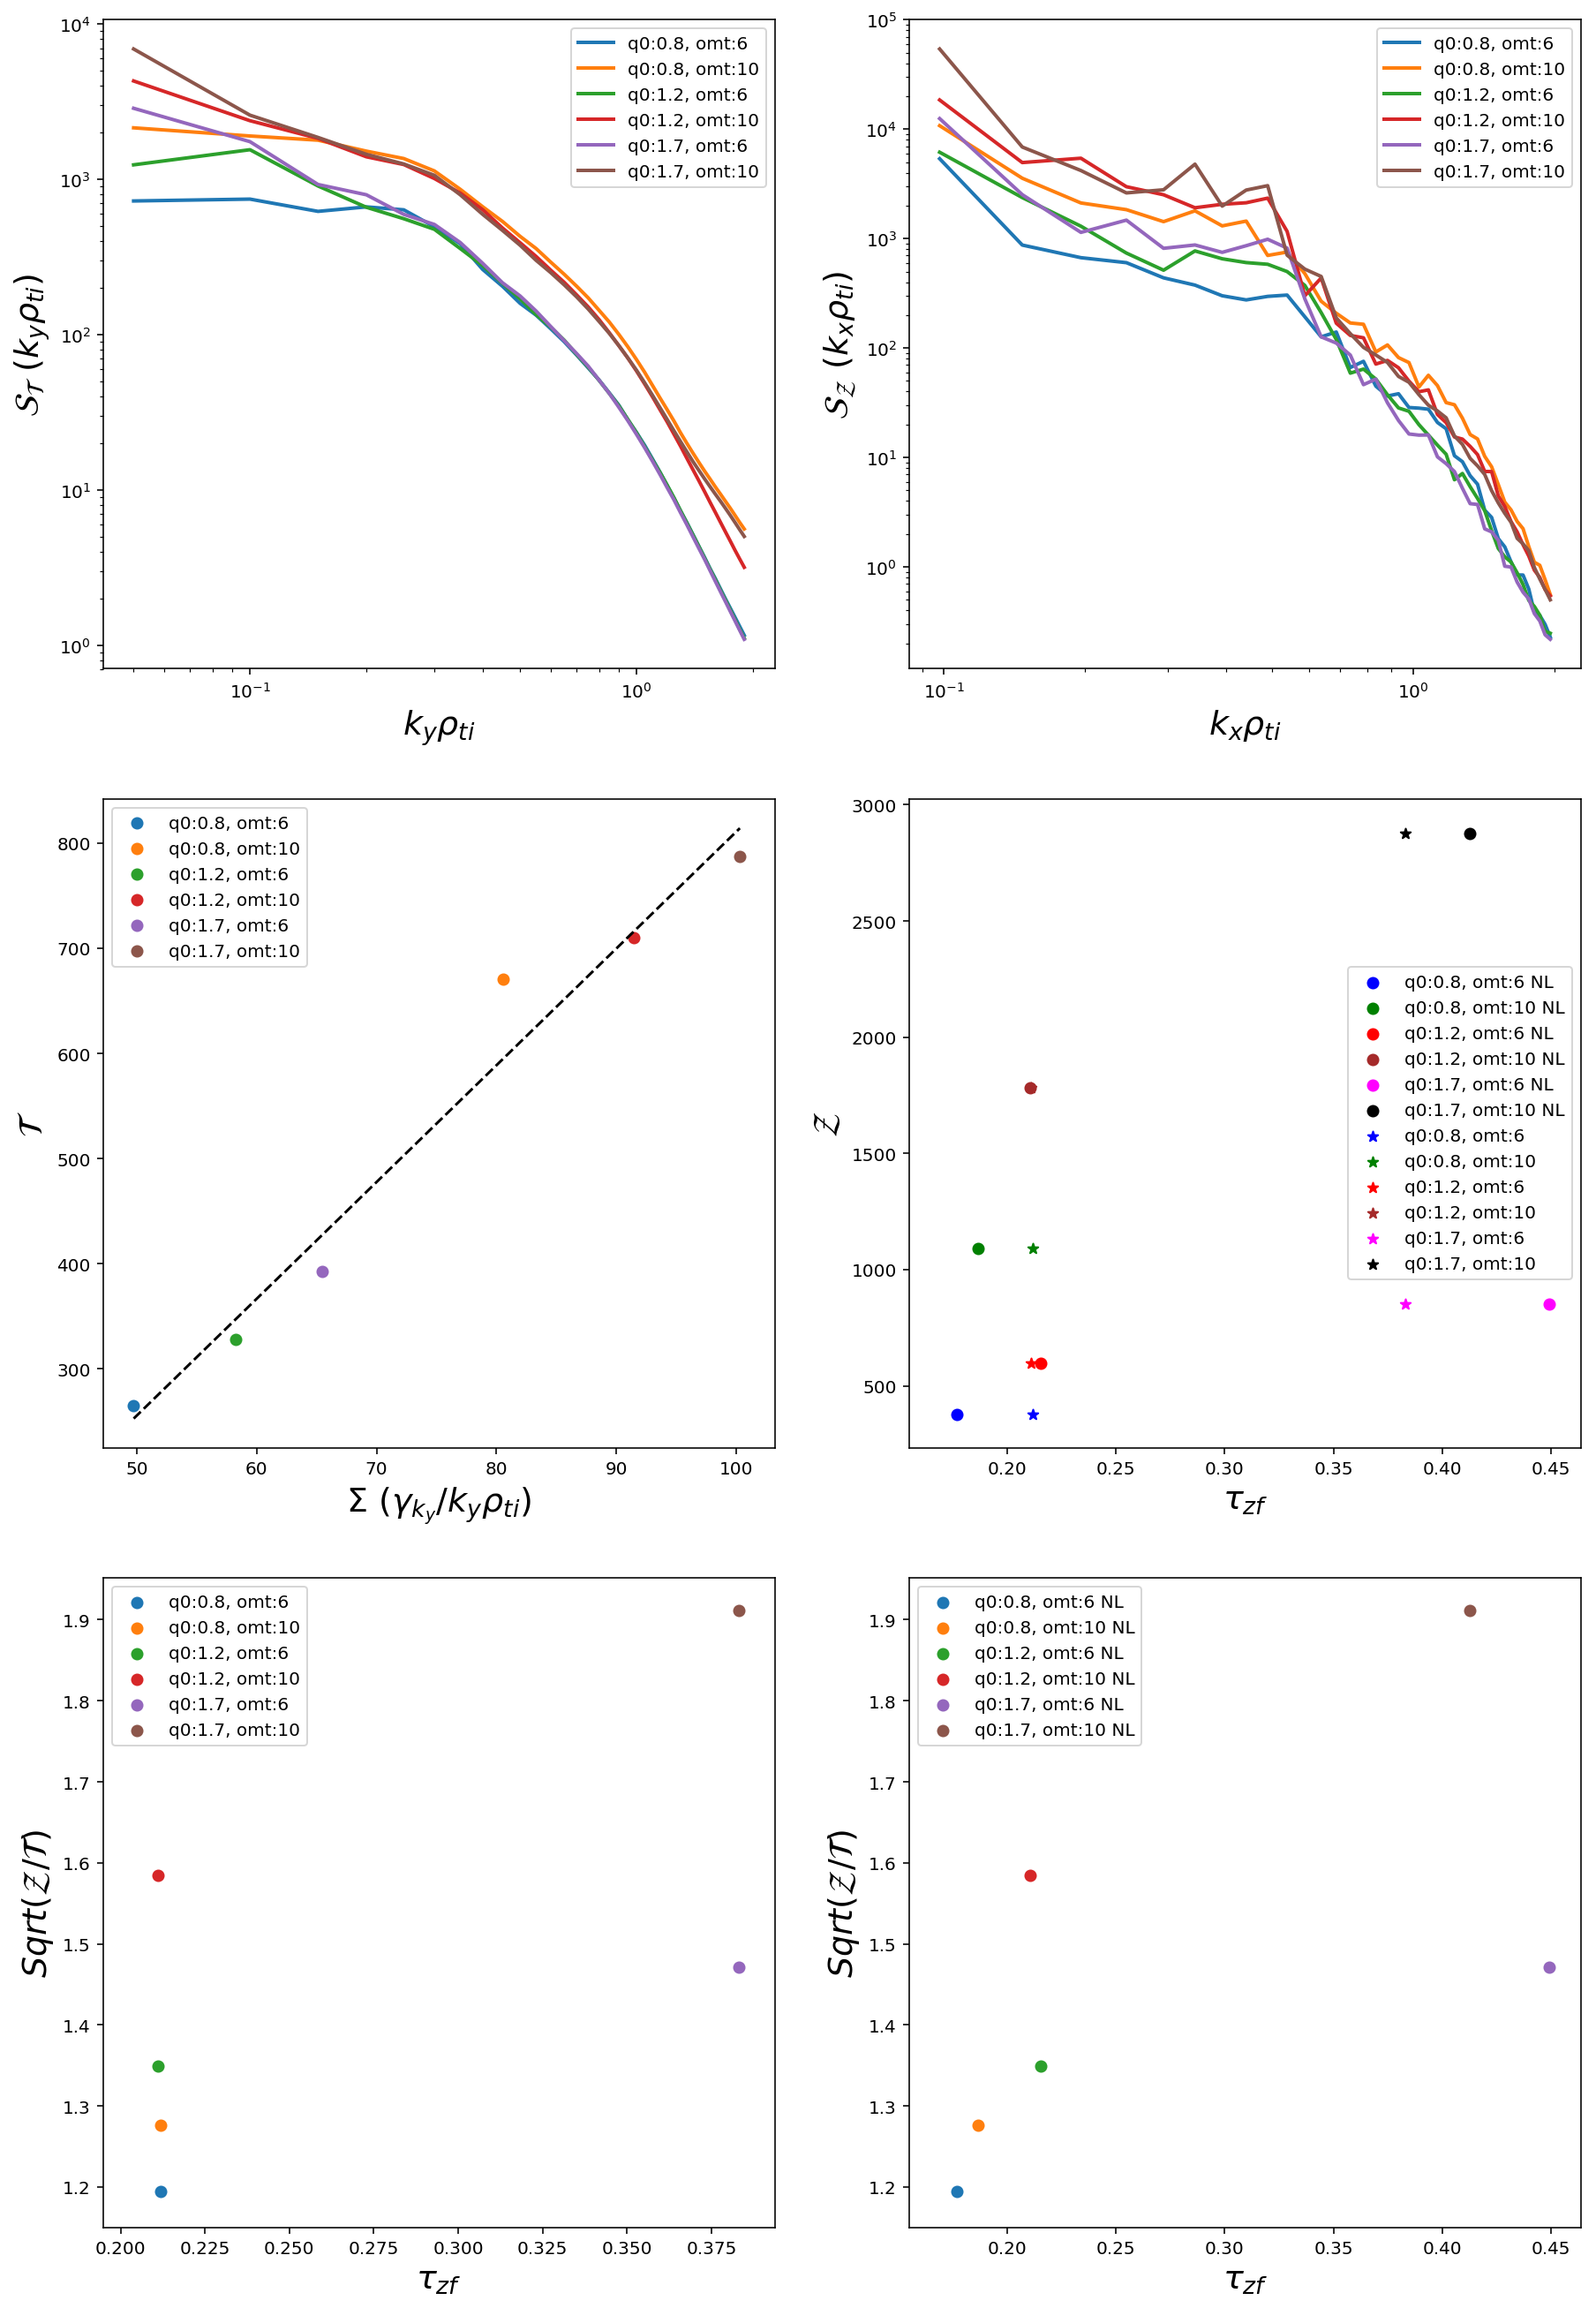

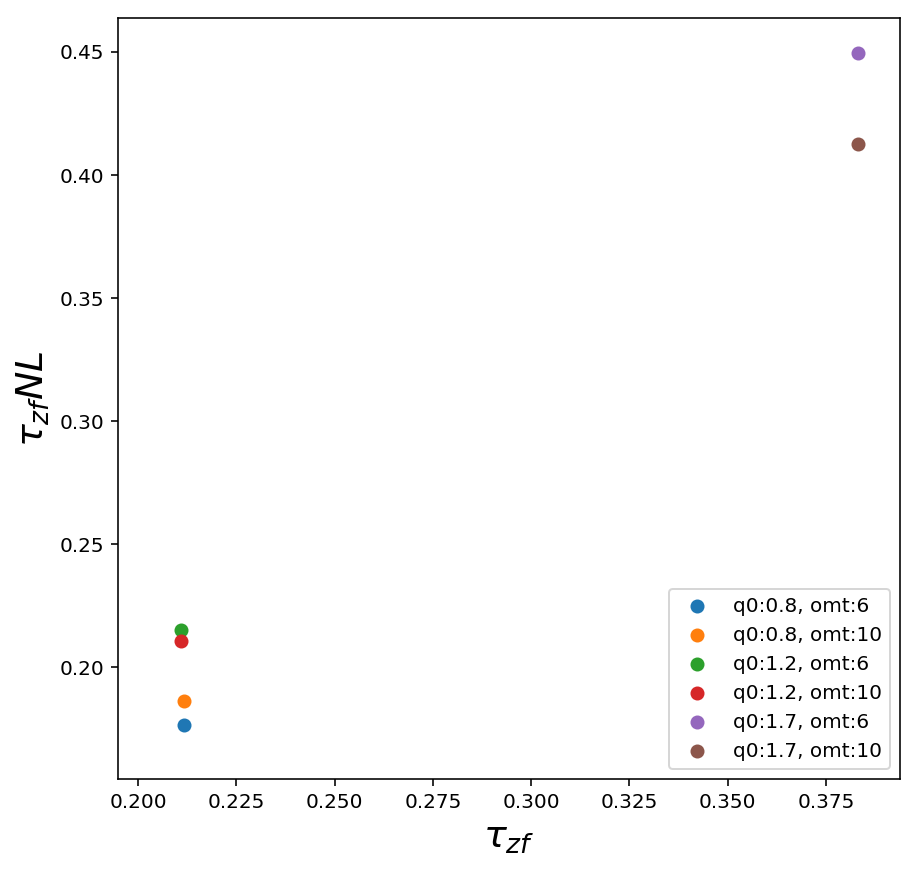

In [40]:
######################################## PUT ALL THE IMPORTANT DATA HERE  ############################################

salpha_te = np.array([te_sa08omt6,
                      te_sa08omt10,
                      te_sa12omt6,
                      te_sa12omt10,
                      te_sa17omt6,
                      te_sa17omt10])

salpha_zet = np.array([zet_sa08omt6,
                       zet_sa08omt10,
                       zet_sa12omt6,
                       zet_sa12omt10,
                       zet_sa17omt6,
                       zet_sa17omt10])

salpha_sigma = np.array([appT_sa08omt6,
                         appT_sa08omt10,
                         appT_sa12omt6,
                         appT_sa12omt10,
                         appT_sa17omt6,
                         appT_sa17omt10])

salpha_zf = np.array([tzf_sa08omt6,
                      tzf_sa08omt10,
                      tzf_sa12omt6,
                      tzf_sa12omt10,
                      tzf_sa17omt6,
                      tzf_sa17omt10])

salpha_zf_nl = np.array([tzf_sa08omt6_nl,
                         tzf_sa08omt10_nl,
                         tzf_sa12omt6_nl,
                         tzf_sa12omt10_nl,
                         tzf_sa17omt6_nl,
                         tzf_sa17omt10_nl])

slope_salpha, intercept, r_value, p_value, std_err = stats.linregress(salpha_sigma, salpha_te)
mod2 = Model(line2)
pars = mod2.make_params(intercept=16, slope=8.0)
out = mod2.fit(salpha_te, pars, x=salpha_sigma, nan_policy='propagate')
x = np.linspace(min(salpha_sigma), max(salpha_sigma), len(out.best_fit))
y = line2(x, slope_salpha, intercept)
#print(out.fit_report(min_correl=0.25))
#print('the slope is:', slope_salpha)

salpha = np.sqrt(salpha_zet/salpha_te)
tau = salpha_zf
tau_nl = salpha_zf_nl
slope_salpha, intercept, r_value, p_value, std_err = stats.linregress(tau, tau_nl)


fig = plt.figure(figsize=(15, 23))

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

ax1.plot(ky_sa08omt6, St_sa08omt6, linewidth=2, label='q0:0.8, omt:6')
ax1.plot(ky_sa08omt10, St_sa08omt10, linewidth=2, label='q0:0.8, omt:10')
ax1.plot(ky_sa12omt6, St_sa12omt6, linewidth=2, label='q0:1.2, omt:6')
ax1.plot(ky_sa12omt10, St_sa12omt10, linewidth=2, label='q0:1.2, omt:10')
ax1.plot(ky_sa17omt6, St_sa17omt6, linewidth=2, label='q0:1.7, omt:6')
ax1.plot(ky_sa17omt10, St_sa17omt10, linewidth=2, label='q0:1.7, omt:10')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$k_{y}  \\rho_{ti}$',fontsize=19)
ax1.set_ylabel('$\mathcal{S}_{\mathcal{T}} \ (k_{y} \\rho_{ti})$',fontsize=19)
ax1.legend(fontsize=10)

ax2.plot(kx_sa08omt6, Sz_sa08omt6, linewidth=2, label='q0:0.8, omt:6')
ax2.plot(kx_sa08omt10, Sz_sa08omt10, linewidth=2, label='q0:0.8, omt:10')
ax2.plot(kx_sa12omt6, Sz_sa12omt6, linewidth=2, label='q0:1.2, omt:6')
ax2.plot(kx_sa12omt10, Sz_sa12omt10, linewidth=2, label='q0:1.2, omt:10')
ax2.plot(kx_sa17omt6, Sz_sa17omt6, linewidth=2, label='q0:1.7, omt:6')
ax2.plot(kx_sa17omt10, Sz_sa17omt10, linewidth=2, label='q0:1.7, omt:10')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('$k_{x}  \\rho_{ti}$',fontsize=19)
ax2.set_ylabel('$\mathcal{S}_{\mathcal{Z}} \ (k_{x} \\rho_{ti})$',fontsize=19)
ax2.legend(fontsize=10)

ax3.scatter(salpha_sigma[0], salpha_te[0], label='q0:0.8, omt:6')
ax3.scatter(salpha_sigma[1], salpha_te[1], label='q0:0.8, omt:10')
ax3.scatter(salpha_sigma[2], salpha_te[2], label='q0:1.2, omt:6')
ax3.scatter(salpha_sigma[3], salpha_te[3], label='q0:1.2, omt:10')
ax3.scatter(salpha_sigma[4], salpha_te[4], label='q0:1.7, omt:6')
ax3.scatter(salpha_sigma[5], salpha_te[5], label='q0:1.7, omt:10')
ax3.plot(x, y, 'k--')
ax3.set_ylabel('$\mathcal{T}$', fontsize=19)
ax3.set_xlabel('$\Sigma \ (\gamma_{k_{y}} / k_{y}\\rho_{ti})$', fontsize=19)
ax3.legend()

ax4.scatter(salpha_zf_nl[0], salpha_zet[0], label='q0:0.8, omt:6 NL', marker='o', color='blue')
ax4.scatter(salpha_zf_nl[1], salpha_zet[1], label='q0:0.8, omt:10 NL', marker='o', color='green')
ax4.scatter(salpha_zf_nl[2], salpha_zet[2], label='q0:1.2, omt:6 NL', marker='o', color='red')
ax4.scatter(salpha_zf_nl[3], salpha_zet[3], label='q0:1.2, omt:10 NL', marker='o', color='brown')
ax4.scatter(salpha_zf_nl[4], salpha_zet[4], label='q0:1.7, omt:6 NL', marker='o', color='magenta')
ax4.scatter(salpha_zf_nl[5], salpha_zet[5], label='q0:1.7, omt:10 NL', marker='o', color='black')
ax4.scatter(salpha_zf[0], salpha_zet[0], label='q0:0.8, omt:6', marker='*', color='blue')
ax4.scatter(salpha_zf[1], salpha_zet[1], label='q0:0.8, omt:10', marker='*', color='green')
ax4.scatter(salpha_zf[2], salpha_zet[2], label='q0:1.2, omt:6', marker='*', color='red')
ax4.scatter(salpha_zf[3], salpha_zet[3], label='q0:1.2, omt:10', marker='*', color='brown')
ax4.scatter(salpha_zf[4], salpha_zet[4], label='q0:1.7, omt:6', marker='*', color='magenta')
ax4.scatter(salpha_zf[5], salpha_zet[5], label='q0:1.7, omt:10', marker='*', color='black')
ax4.set_ylabel('$\mathcal{Z}$', fontsize=19)
ax4.set_xlabel('$\\tau_{zf}$', fontsize=19)
ax4.legend()

ax5.scatter(salpha_zf[0], np.sqrt(salpha_zet[0]/salpha_te[0]), label='q0:0.8, omt:6')
ax5.scatter(salpha_zf[1], np.sqrt(salpha_zet[1]/salpha_te[1]), label='q0:0.8, omt:10')
ax5.scatter(salpha_zf[2], np.sqrt(salpha_zet[2]/salpha_te[2]), label='q0:1.2, omt:6')
ax5.scatter(salpha_zf[3], np.sqrt(salpha_zet[3]/salpha_te[3]), label='q0:1.2, omt:10')
ax5.scatter(salpha_zf[4], np.sqrt(salpha_zet[4]/salpha_te[4]), label='q0:1.7, omt:6')
ax5.scatter(salpha_zf[5], np.sqrt(salpha_zet[5]/salpha_te[5]), label='q0:1.7, omt:10')
ax5.set_ylabel('$Sqrt(\mathcal{Z}/\mathcal{T})$', fontsize=19)
ax5.set_xlabel('$\\tau_{zf}$', fontsize=19)
ax5.legend()

ax6.scatter(salpha_zf_nl[0], np.sqrt(salpha_zet[0]/salpha_te[0]), label='q0:0.8, omt:6 NL')
ax6.scatter(salpha_zf_nl[1], np.sqrt(salpha_zet[1]/salpha_te[1]), label='q0:0.8, omt:10 NL')
ax6.scatter(salpha_zf_nl[2], np.sqrt(salpha_zet[2]/salpha_te[2]), label='q0:1.2, omt:6 NL')
ax6.scatter(salpha_zf_nl[3], np.sqrt(salpha_zet[3]/salpha_te[3]), label='q0:1.2, omt:10 NL')
ax6.scatter(salpha_zf_nl[4], np.sqrt(salpha_zet[4]/salpha_te[4]), label='q0:1.7, omt:6 NL')
ax6.scatter(salpha_zf_nl[5], np.sqrt(salpha_zet[5]/salpha_te[5]), label='q0:1.7, omt:10 NL')
ax6.set_ylabel('$Sqrt(\mathcal{Z}/\mathcal{T})$', fontsize=19)
ax6.set_xlabel('$\\tau_{zf}$', fontsize=19)
ax6.legend()

plt.show()

plt.figure(figsize=(7, 7))
plt.scatter(tau[0], tau_nl[0], label='q0:0.8, omt:6')
plt.scatter(tau[1], tau_nl[1], label='q0:0.8, omt:10')
plt.scatter(tau[2], tau_nl[2], label='q0:1.2, omt:6')
plt.scatter(tau[3], tau_nl[3], label='q0:1.2, omt:10')
plt.scatter(tau[4], tau_nl[4], label='q0:1.7, omt:6')
plt.scatter(tau[5], tau_nl[5], label='q0:1.7, omt:10')
plt.ylabel('$\\tau_{zf} NL$', fontsize=19)
plt.xlabel('$\\tau_{zf}$', fontsize=19)
plt.legend(loc='lower right')
#plt.savefig('tau_sum_plot.eps', format='eps', dpi=1200)
#print('the slope is:', slope_salpha)
plt.show()

In [ ]:
fig = plt.figure(figsize=(6, 4))

ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(222)
#ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)

ax1.scatter(salpha_sigma[0], salpha_te[0], label='q0:0.8, omt:6')
ax1.scatter(salpha_sigma[1], salpha_te[1], label='q0:0.8, omt:10')
ax1.scatter(salpha_sigma[2], salpha_te[2], label='q0:1.2, omt:6')
ax1.scatter(salpha_sigma[3], salpha_te[3], label='q0:1.2, omt:10')
ax1.scatter(salpha_sigma[4], salpha_te[4], label='q0:1.7, omt:6')
ax1.scatter(salpha_sigma[5], salpha_te[5], label='q0:1.7, omt:10')
ax1.plot(x, y, 'k--')

ax1.set_ylabel('$\mathcal{T}$', fontsize=14)
ax1.set_xlabel('$\Sigma \ (\gamma_{k_{y}} / k_{y}\\rho_{ti})$', fontsize=14)
#ax1.legend()
plt.savefig('tau_sum_plot.eps', format='eps', dpi=1200)

In [ ]:
## Kx space generator for linear zonal flow response simulation for input parameters
Lx = 759.005
kx_minimum = 2*np.pi/Lx
nkx0 = 128

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
a = np.linspace((kx_minimum), (kx_minimum)*((nkx0//2)-1), (nkx0//2)-1)
b = (2*np.pi)/a
for m in range(len(b)):
    print(np.array2string(b[m]), end=",", flush=True)
print()
print(np.array2string(a, separator=', '))

In [ ]:
## IDL Diagnostic kx space generator for amplitude spectra
nkx0 = 384
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
a = np.linspace(0, (nkx0//2)-1, nkx0//2)  # nkx0/2 - 1, be careful to neglect the last one
for m in range(len(a)):
    print(np.array2string(a[m]), end=",", flush=True)

In [ ]:
## Ky space generator for the linear response of instabilities in the parameters file

ky_min = 0.05
nky0 = 64
a = np.linspace(ky_min, (nky0) * ky_min, nky0)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
for m in range(len(a)):
    print(np.array2string(a[m]), end=",", flush=True)

In [ ]:
len(a)